In [1]:
from astropy.io import fits
import os
import subprocess
from astropy.table import Table
import numpy as np
from astropy.io import ascii
import time

import os
import numpy as np
from PIL import Image
import PIL.ImageOps    
from astropy.io import fits
from astropy.table import Table

import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
import image_registration
from astropy.nddata import Cutout2D
from astropy import units as u
import matplotlib.image as mpimg

from __future__ import print_function
#import cv2
import numpy as np

# from photutils import DAOStarFinder
# from photutils import CircularAperture
# from photutils import aperture_photometry

from astropy.stats import sigma_clipped_stats

from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

 
import pandas as pd
import pandasql as ps
plt.style.use(astropy_mpl_style)

#from regions.core import PixCoord
#from regions.shapes.circle import CirclePixelRegion
import scipy.misc
import time

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

In [2]:
def saveImData(imData,name):
    im = fits.PrimaryHDU(imData)
    hdub = fits.HDUList([im])
    hdub.writeto(name)

In [3]:
def getImageData(imageName,extension):
    hdu = fits.open(imageName)
    imageData = hdu[extension].data
    return imageData

In [4]:
def getImageHeader(imageName,extension):
    hdu = fits.open(imageName)
    imageData = hdu[extension].header
    return imageData

In [5]:
def assessQuality(output,sqlQuery,refPandasNew):
    pandasTable = Table.to_pandas(output)
    newdf = ps.sqldf(sqlQuery,locals())
    Nrecovered = len(newdf)
    Ntarget = len(refPandasNew)
    Ntot = len(pandasTable)
    return [Nrecovered,Ntarget,Ntot]

In [6]:
def sextractor(imagename,valList,sextractoryDir='/home/mj1e16/sextractor/sextractor-master/config/',cataloguename='/home/mj1e16/sextractor/sextractor-master/config/moleTable.cat',tableDir='/home/mj1e16/moleGazer/Photos/F/fitsImages/simMolePos/'):
    imTabName = imagename.replace('.fits','')
    loc1 = imTabName.rfind('/') + 1
    imTabName = imTabName[loc1:]+'{}_{}_{}'.format(valList[0],valList[1],valList[2])+'.cat'
    os.chdir(sextractoryDir)
    subprocess.call(['sex',imagename,'-c','default_1.sex'])
    assoc = Table.read(cataloguename,format='ascii.sextractor')
    subprocess.call(['cp',cataloguename,tableDir+imTabName])
    return assoc

In [7]:
def makeDS9RegFile(sexTabList,fileNameBase,tabType,colour='red',radius='10'):
    for tables in range(len(sexTabList)):
        if tabType == 'dao':
            xcoords = sexTabList[tables]['xcentroid']
            ycoords = sexTabList[tables]['ycentroid']
        elif tabType == 'sexMedian':
            ra = sexTabList[tables]['RA']
            dec = sexTabList[tables]['DEC']
        elif tabType == 'sex':
            xcoords = sexTabList[tables]['X_IMAGE']
            ycoords = sexTabList[tables]['Y_IMAGE']
        elif tabType == 'iraf':
            xcoords = sexTabList[tables]['X_POS']
            ycoords = sexTabList[tables]['Y_POS']        
        else:
            print('tab type error')
            break
        bigString = 'image\n'
        for x in range(len(xcoords)):
            bigString += 'circle({},{},'.format(xcoords[x],ycoords[x])+radius+') # color={}\n'.format(colour)
        fileName = fileNameBase + '.reg'
        with open(fileName,'w') as f:
            f.write(bigString)
            
    return fileName

In [8]:
def makeConfig(valList,tableName='moleTable.cat',defaultDir='/home/mj1e16/sextractor/sextractor-master/config/',attributeList=['DETECT_THRESH','DETECT_MINAREA','FILTER_NAME']):
    
    with open(defaultDir+'/default.sex','r') as f:
        data  = f.read()
    for x in range(len(valList)):
        nameLoc = data.find(attributeList[x]) + len(attributeList[x])
        endLoc = data[nameLoc:].find('#') + nameLoc
        newData = data[:nameLoc] + ' '+str(valList[x])+' ' + data[endLoc:]
        data = newData
    
    cname = 'CATALOG_NAME'
    catName = tableName#'test1.cat'
    confName = 'default_1.sex'
    nameLoc = data.find(cname) + len(cname)
    endLoc = data[nameLoc:].find('#') + nameLoc
    newData = data[:nameLoc] + ' ' +catName+ ' ' + data[endLoc:]
    data = newData

    cname = 'PARAMETERS_NAME'
    nameLoc = data.find(cname) + len(cname)
    endLoc = data[nameLoc:].find('#') + nameLoc
    newData = data[:nameLoc] + ' autodefault.param ' + data[endLoc:]
    
    #print(newData)
    with open(defaultDir+confName,'w') as f:
        f.write(newData)
    return(confName,tableName,catName)

In [9]:
def findObjects(valList,image):
    makeConfig(valList)
    tabTot =  sextractor(image,valList)
    return tabTot

In [10]:
# def findObjects(sextractoryDir,imagename,cataloguename='/home/mj1e16/sextractor/sextractor-master/config/moleTable.cat',tableDir='/home/mj1e16/moleGazer/Photos/F/fitsImages/simMolePos/'):
#     imTabName = imagename.replace('.fits','.csv')
#     loc1 = imTabName.rfind('/') + 1
#     imTabName = imTabName[loc1:]
#     os.chdir(sextractoryDir)
#     subprocess.call(['sex',imagename,'-c','default_1.sex'])
#     assoc = Table.read(cataloguename,format='ascii.sextractor')
#     subprocess.call(['cp',sextractoryDir+cataloguename,tableDir+imTabName])
#     return assoc

In [11]:
def saveSexTabasReg(table,regFileName='baseRegions.reg',regDirectory='/home/mj1e16/moleGazer/MoleGazer/regionDirectory/',aperture=15):
    xcoords = table['X_IMAGE'].tolist()
    ycoords = table['Y_IMAGE'].tolist()
    string = ''
    for x in range(len(xcoords)):
        string += 'circle({},{},{})\n'.format(xcoords[x],ycoords[x],aperture)
    with open(regDirectory+regFileName,'w') as f:
        f.write(string)

In [12]:
def transform16Bit(imageName,outImageName): 
    data = getImageData(imageName,0)
    hdu = fits.PrimaryHDU(data)
    hdu.data = np.int16(hdu.data)
    hdu.writeto(outImageName)

In [13]:
def showImageWithResults(valList,image,imageDir):
    tab = findObjects(valList,imageDir+image)
    saveSexTabasReg(tab)
    regions = makeDS9RegFile([tab],'/home/mj1e16/moleGazer/MoleGazer/regionDirectory/baseRegions','sex')
    print(imageDir+image)
    print(regions)
    subprocess.call(['ds9',imageDir+image,'-regions',regions])

In [14]:
def cropImage(image,ImDir):
    imData = getImageData(ImDir+image,0)
    ylength = imData.shape[0]
    cropHeight = int(ylength* 1./38.)
    imData[0:cropHeight] = 0
    hdu = fits.PrimaryHDU(imData)
    imageOut = image.replace('.fits','Cropped.fits')
    hdu.writeto(ImDir+'Cropped/'+imageOut)
    return imageOut

In [15]:
# def normaliseImage(baseImage,targetImage): # needs analogue of which image is normalised
#     baseVal = 

In [16]:
def molePositions2Tab(molePositions):
    with open(molePositions,'r') as f:
        data = f.readlines()

    ycoord = []
    xcoord = []
    starLocations = []
    for x in data:
        if 'circle(' in x:
            locator1 = '('
            locator2 = ','
            loc1 = x.index(locator1) +1
            #print(x)
            loc2 = x[loc1:].index(locator2) + loc1 +1
            loc3 = x[loc2:].index(locator2) + loc2
            xcoord.append(x[loc1:loc2-1])
            ycoord.append(x[loc2:loc3])
            #starLocations.append([float(xcoord),float(ycoord)])
    tollerance = 5

    xUpper = [float(x) + tollerance for x in xcoord]
    xLower = [float(x) - tollerance for x in xcoord]
    yUpper = [float(x) + tollerance for x in ycoord]
    yLower = [float(x) - tollerance for x in ycoord]

    refDict = {'index':range(len(xcoord)),'xcoord':xcoord,'ycoord':ycoord,'xUpper':xUpper,'xLower':xLower,
              'yUpper':yUpper,'yLower':yLower}
    refPandasNew = pd.DataFrame(data=refDict)
    return refPandasNew

In [17]:
sqlcode = '''
SELECT *
FROM pandasTable
JOIN refPandasNew
ON pandasTable.X_IMAGE < refPandasNew.xUpper
AND pandasTable.X_IMAGE > refPandasNew.xLower
AND pandasTable.Y_IMAGE < refPandasNew.yUpper
AND pandasTable.Y_IMAGE > refPandasNew.yLower
'''

In [18]:
valList = [np.linspace(1,50,10),np.linspace(1,100,20),['default.conv','gauss_1.5_3x3.conv','gauss_2.0_3x3.conv','gauss_2.0_5x5.conv',
                                                    'gauss_2.5_5x5.conv','gauss_3.0_5x5.conv','gauss_3.0_7x7.conv',
                                                    'gauss_4.0_7x7.conv','gauss_5.0_9x9.conv','mexhat_1.5_5x5.conv',
                                                    'mexhat_2.0_7x7.conv','mexhat_2.5_7x7.conv','mexhat_3.0_9x9.conv',
                                                    'mexhat_4.0_9x9.conv','mexhat_5.0_11x11.conv','tophat_1.5_3x3.conv',
                                                    'tophat_2.0_3x3.conv','tophat_2.5_3x3.conv','tophat_3.0_3x3.conv',
                                                    'tophat_4.0_5x5.conv','tophat_5.0_5x5.conv']]

In [81]:
dirlist = os.listdir('/home/mj1e16/moleGazer/Photos/F/fitsImages/')
regList = [x for x in dirlist if '.reg' in x]
regList.sort()
imageList = [x for x in dirlist if '.fits' in x]
imageList.sort()

In [94]:
for x in imageList:
    croppedIm = cropImage(x,'/home/mj1e16/moleGazer/Photos/F/fitsImages/')
    moleImNewFormat = croppedIm.replace('.fits','16.fits')
    transform16Bit('/home/mj1e16/moleGazer/Photos/F/fitsImages/Cropped/'+croppedIm,'/home/mj1e16/moleGazer/Photos/F/fitsImages/16bit/'+moleImNewFormat)
    

In [93]:
sextractorReady = os.listdir('/home/mj1e16/moleGazer/Photos/F/fitsImages/16bit/')
sextractorReady.sort()

In [90]:
panTabs = []
for x in regList:
    panTabs.append(molePositions2Tab('/home/mj1e16/moleGazer/Photos/F/fitsImages/'+x))

In [101]:
showImageWithResults([1,1,'default.conv'],'29005InvertedAverageCropped16.fits','/home/mj1e16/moleGazer/Photos/F/fitsImages/16bit/')

/home/mj1e16/moleGazer/Photos/F/fitsImages/16bit/29005InvertedAverageCropped16.fits
/home/mj1e16/moleGazer/MoleGazer/regionDirectory/baseRegions.reg


In [109]:
t0 = time.time()



for imNum in range(len(sextractorReady)):
    t1 = time.time()
    Nrecovered = []
    Ntarget = []
    Ntot = []
    settings = []
    
    fakeHeadMoleIM = '/home/mj1e16/moleGazer/Photos/F/fitsImages/16bit/'+sextractorReady[imNum]
    refPandasNew = panTabs[imNum]
    
    for x in range(len(valList[0])):
        for y in range(len(valList[1])):
            for z in range(len(valList[2])):
                output = findObjects([valList[0][x],valList[1][y],valList[2][z]],fakeHeadMoleIM)
                quality = assessQuality(output,sqlcode,refPandasNew)
                Nrecovered.append(quality[0])
                Ntarget.append(quality[1])
                Ntot.append(quality[2])
                settings.append([valList[0][x],valList[1][y],valList[2][z]])
    print(time.time() - t1)
    ogImNum = regList[imNum].replace('.reg','')
    with open('/home/mj1e16/moleGazer/Photos/F/fitsImages/simMolePos/{}_results.py'.format(ogImNum),'w') as f:
        f.write('\nsettings = '+str(settings)+'\nNrecovered = '+str(Nrecovered)+'\nNtarget = '+str(Ntarget)+'\nNtot = '+str(Ntot))
        
print(time.time() -t0)

4756.87189507
4745.2278161
4620.50540209
4678.67902803
4515.49272394
4706.35560608
4624.75341678
4502.28358388
2453.76372504
2412.98990512
2119.95987201
2193.48564196
4421.90927386
4546.42642903
4337.19983697
4480.83576798
4751.71575189
4580.71403503
4402.56785607
4832.98507094
4525.05254793
4677.83559799
3193.60711002
3139.55360484
3219.72456288
3641.7944088
4369.82811594
4161.57213306
4400.17170501
4633.58975506
122647.896698


In [103]:
testData = getImageData('/home/mj1e16/moleGazer/Photos/F/fitsImages/16bit/29005InvertedAverageCropped16.fits',0)

In [104]:
np.std(testData)

38.335574970452448

In [116]:
# command = ['ds9']
# for x in range(len(valList[0])):
#     for y in range(len(valList[1])):
#         command.extend([fakeHeadMoleIM,'-regions','sextest_{}_{}.reg'.format(x,y),'-scale','mode','zscale'])
# command.extend(['-frame','lock','image'])
# #print(command)
# subprocess.call(command)

In [238]:
subprocess.call(['cp','/home/mj1e16/sextractor/sextractor-master/config/outputSextractorNew.py','/home/mj1e16/moleGazer/MoleGazer'])

0

In [239]:
import outputSextractorNew as o2

In [240]:
reload(outputSextractorNew)

<module 'outputSextractorNew' from 'outputSextractorNew.py'>

In [241]:
o2.Nrecovered

[35,
 33,
 35,
 31,
 34,
 37,
 39,
 43,
 38,
 488,
 439,
 363,
 298,
 201,
 145,
 36,
 33,
 35,
 33,
 35,
 42,
 35,
 32,
 35,
 31,
 34,
 37,
 39,
 43,
 38,
 109,
 187,
 205,
 207,
 188,
 143,
 35,
 31,
 35,
 33,
 35,
 42,
 35,
 32,
 35,
 31,
 34,
 37,
 39,
 43,
 38,
 29,
 78,
 113,
 132,
 170,
 138,
 35,
 31,
 35,
 33,
 35,
 42,
 35,
 32,
 35,
 31,
 34,
 37,
 39,
 43,
 38,
 11,
 39,
 55,
 82,
 153,
 131,
 34,
 31,
 35,
 33,
 35,
 42,
 34,
 32,
 35,
 31,
 34,
 37,
 39,
 43,
 38,
 9,
 21,
 30,
 41,
 129,
 127,
 34,
 31,
 34,
 32,
 35,
 42,
 34,
 32,
 33,
 31,
 34,
 37,
 39,
 43,
 38,
 3,
 15,
 17,
 22,
 99,
 115,
 33,
 31,
 33,
 32,
 35,
 42,
 33,
 32,
 33,
 31,
 34,
 37,
 39,
 43,
 38,
 2,
 12,
 13,
 13,
 77,
 104,
 32,
 31,
 33,
 32,
 35,
 42,
 32,
 32,
 32,
 31,
 34,
 37,
 39,
 43,
 38,
 1,
 6,
 8,
 8,
 50,
 95,
 32,
 31,
 32,
 32,
 35,
 42,
 32,
 32,
 32,
 31,
 34,
 37,
 39,
 43,
 38,
 1,
 2,
 6,
 8,
 34,
 82,
 32,
 31,
 32,
 32,
 35,
 42,
 32,
 32,
 32,
 31,
 34,
 37,
 39,
 43,
 38,

In [242]:
outPutNecovered = o.Nrecovered
outPutNtarget = o.Ntarget
completeNess = [float(x)/float(y) if y != 0 else 0 for x, y in zip(outPutNecovered,outPutNtarget)]

In [243]:
Nmax = max(o.Ntot)
accuracy = [float(x)/float(Nmax) for x in o.Ntot]

In [244]:
compPerFilter = [[] for x in range(len(valList[2]))]
accPerfilter = [[] for x in range(len(valList[2]))]
settingsPerFilter = [[] for x in range(len(valList[2]))]
for x in range(len(valList[2])):
    for y in range(int(len(completeNess)/len(valList[2]))):
        #print((y*len(valList[2])+x))
        compPerFilter[x].append(completeNess[(y*len(valList[2])+x)])
        settingsPerFilter[x].append(o.settings[(y*len(valList[2])+x)])
        accPerfilter[x].append(accuracy[(y*len(valList[2])+x)])

In [245]:
fullwhm = valList[0]
threshold = valList[1]

In [246]:
(accPerfilter[19])

[0.12291638573962471,
 0.08040909892435197,
 0.059497754312446194,
 0.047237233810822864,
 0.03906355347640732,
 0.03360751812627714,
 0.029593286794527367,
 0.02666818799464769,
 0.024344705259991495,
 0.02227016710404846,
 0.020413455454479448,
 0.01909612372545562,
 0.018048481956704387,
 0.01686599520781686,
 0.015828726129845344,
 0.0149781654859087,
 0.014158722914311202,
 0.013422261868951424,
 0.012737664277490224,
 0.01212567552148703,
 0.011638159054840416,
 0.011119524515854658,
 0.01070461688466605,
 0.010227473108799153,
 0.009791820096051116,
 0.009532502826558237,
 0.00907610443225077,
 0.008827159853537606,
 0.008464115676247575,
 0.008225543788314126,
 0.007893617683363241,
 0.007572064269192071,
 0.007333492381258622,
 0.007146783947223749,
 0.006918584750070016,
 0.006742249006814858,
 0.006514049809661124,
 0.0063480867571856815,
 0.0061613783231508085,
 0.006016160652234796,
 0.07021274388789196,
 0.055525013743815285,
 0.04747580569875631,
 0.041791571151472404,
 

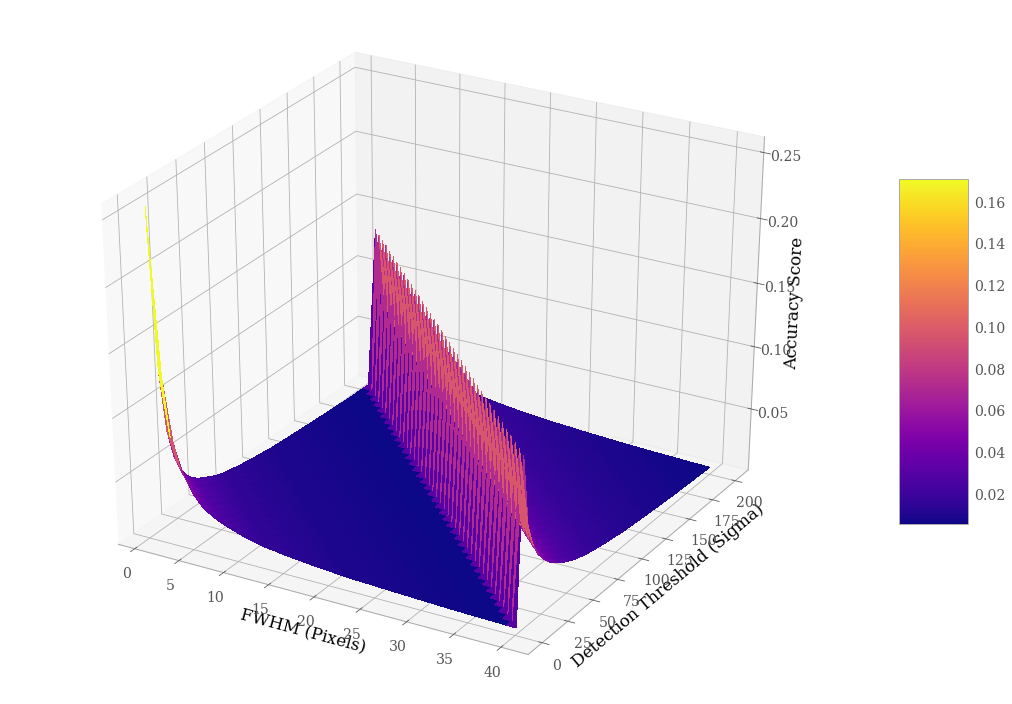

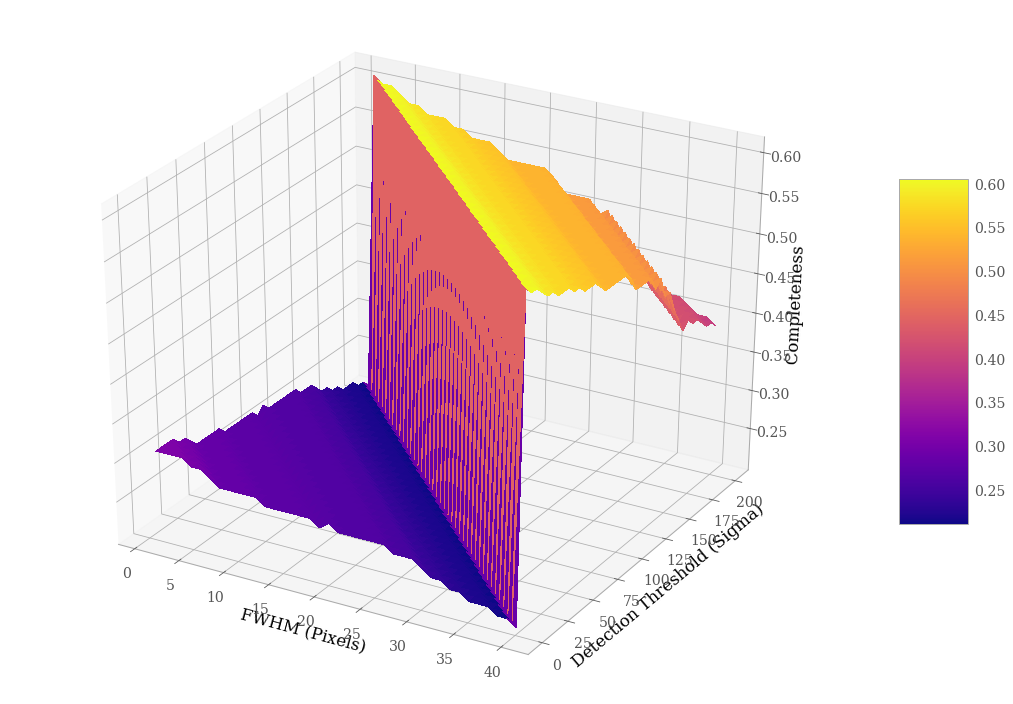

default.conv


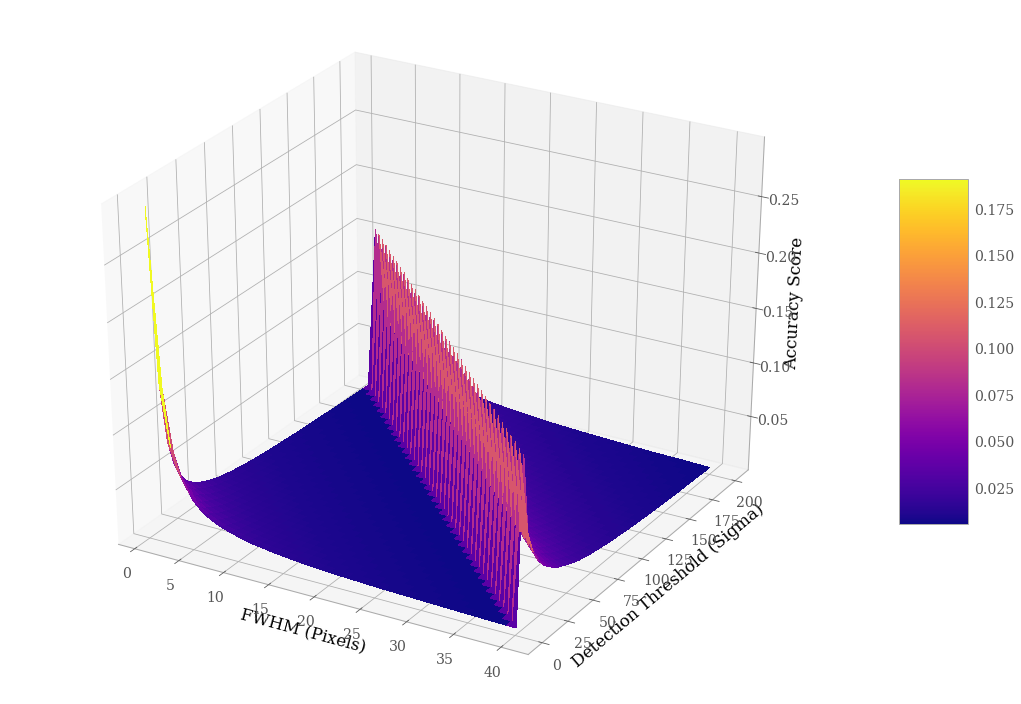

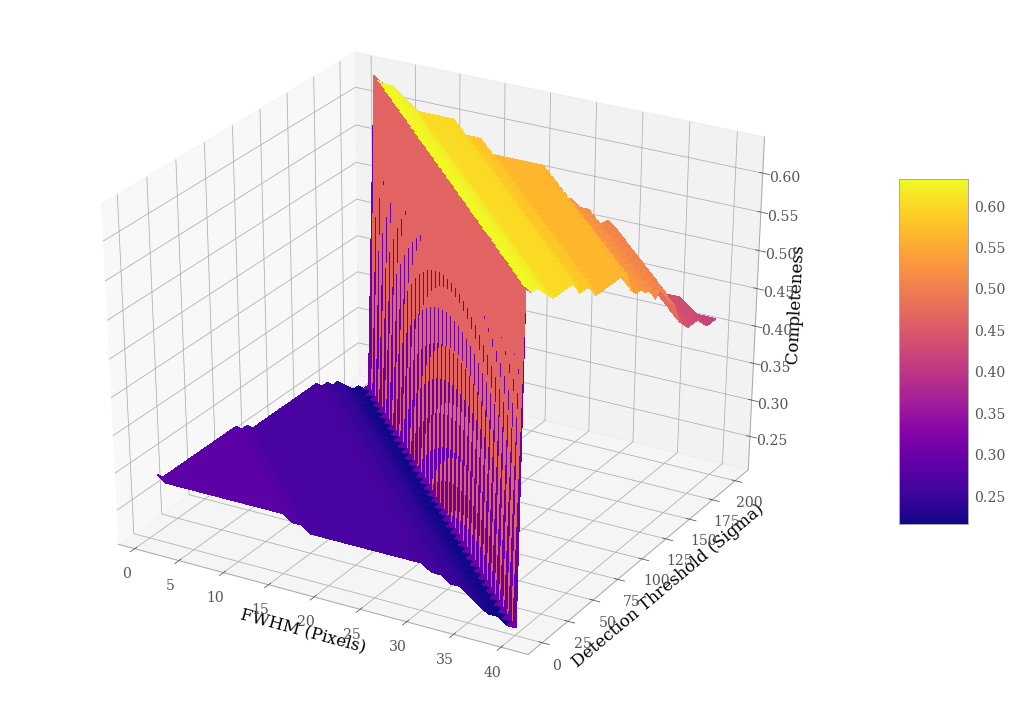

gauss_1.5_3x3.conv


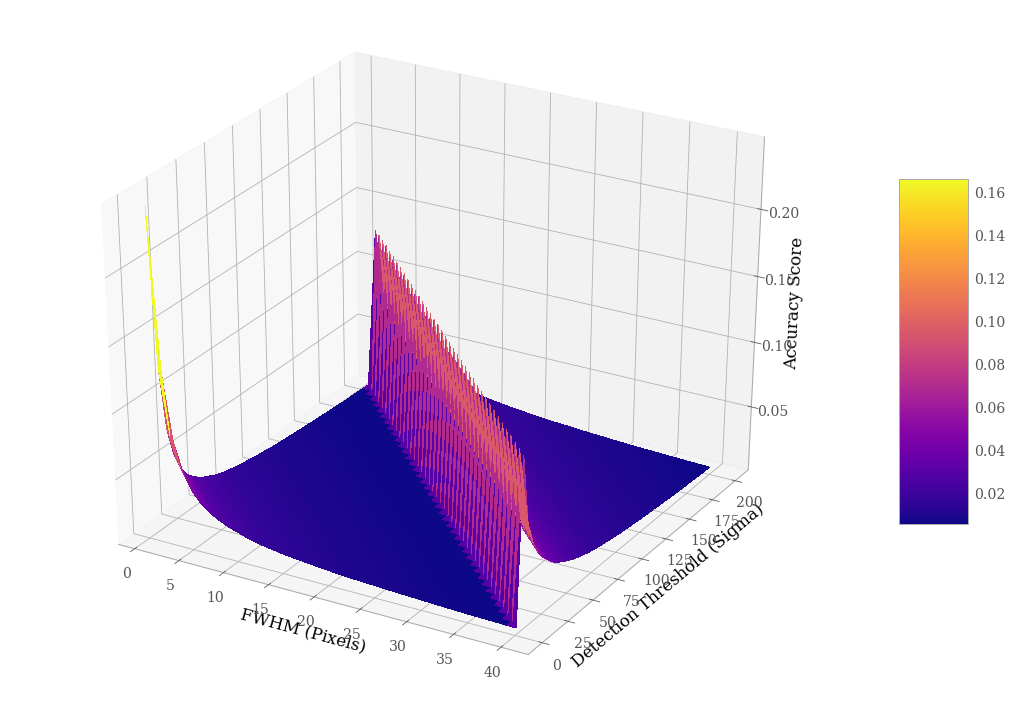

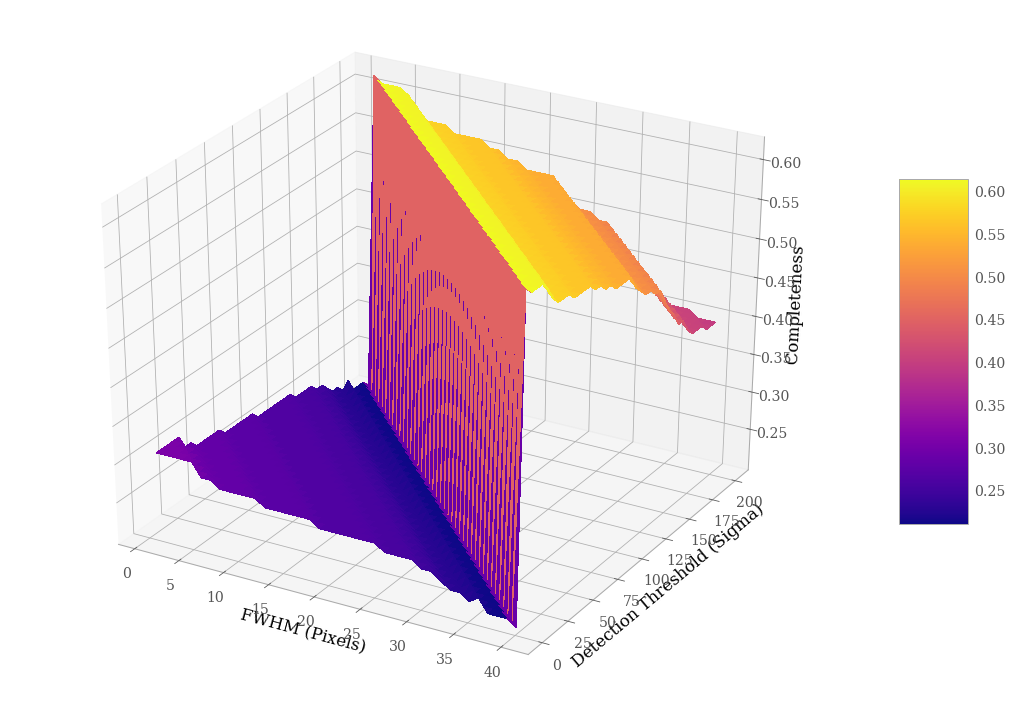

gauss_2.0_3x3.conv


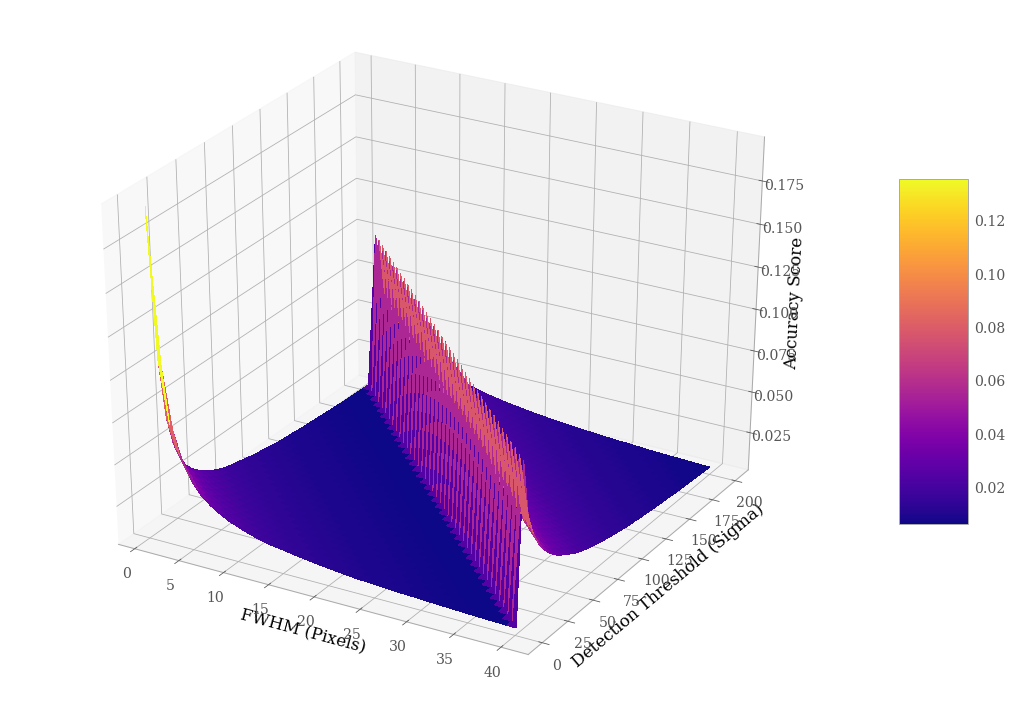

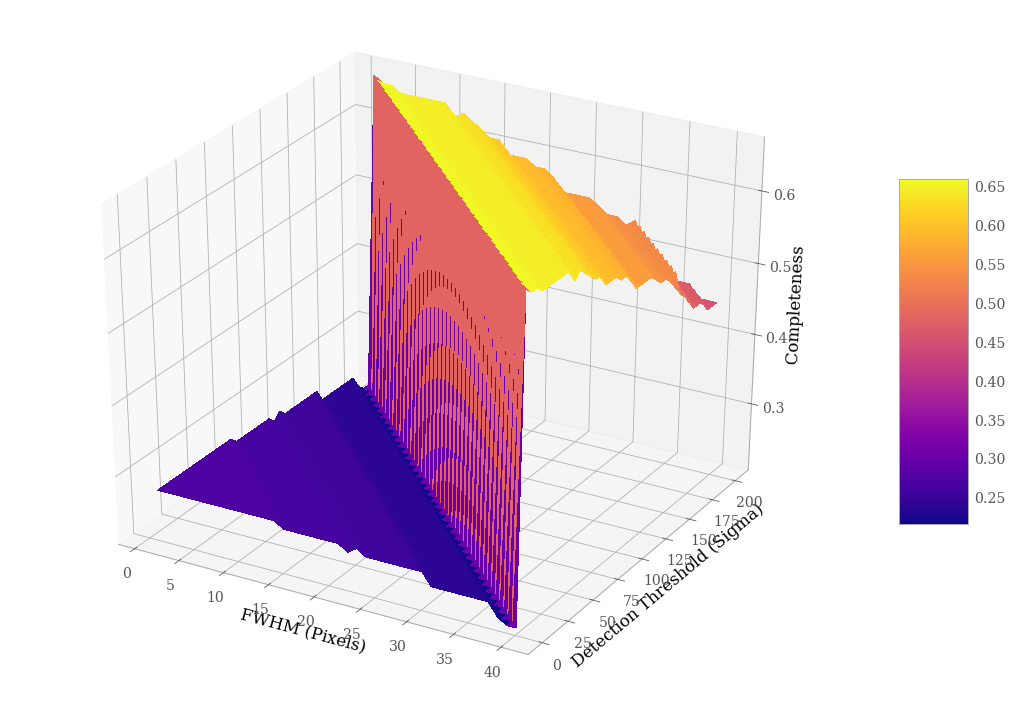

gauss_2.0_5x5.conv


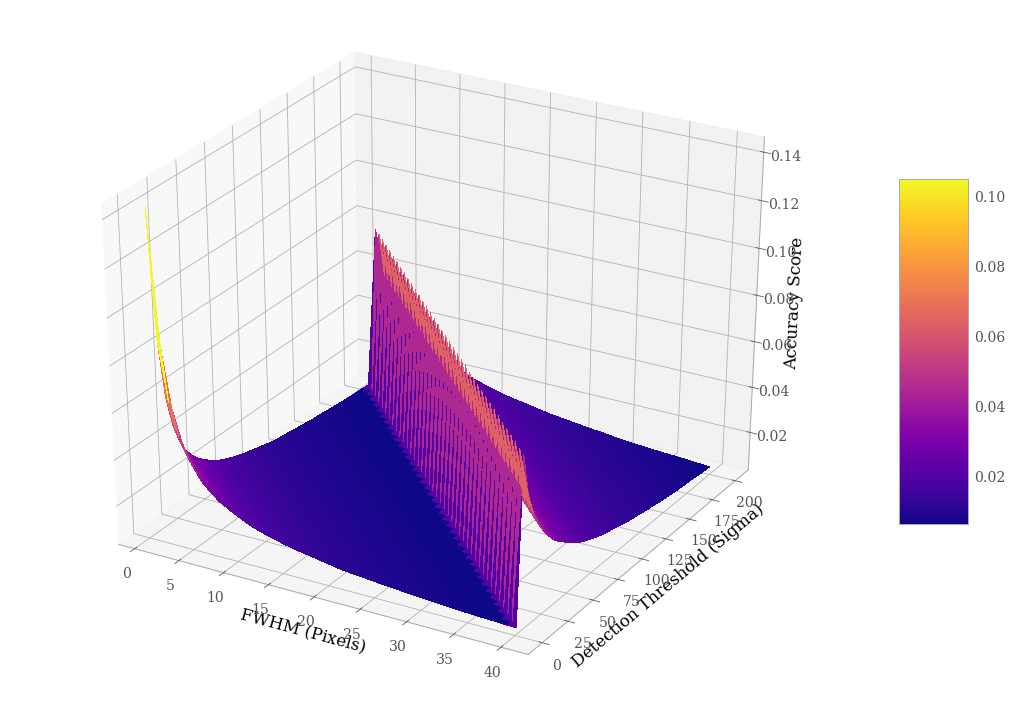

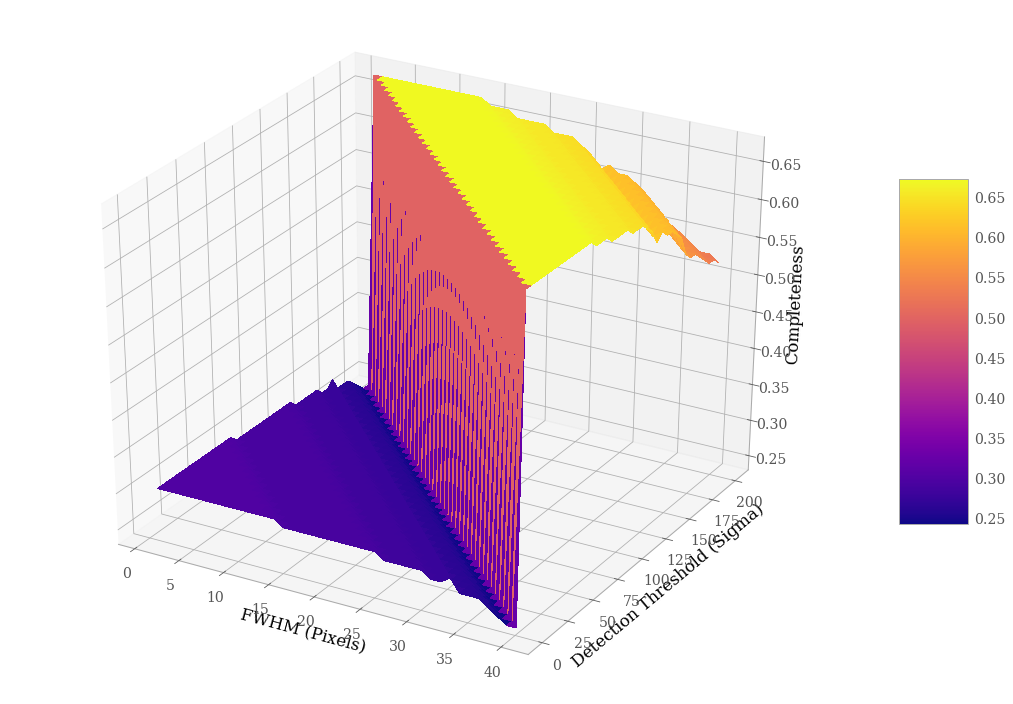

gauss_2.5_5x5.conv


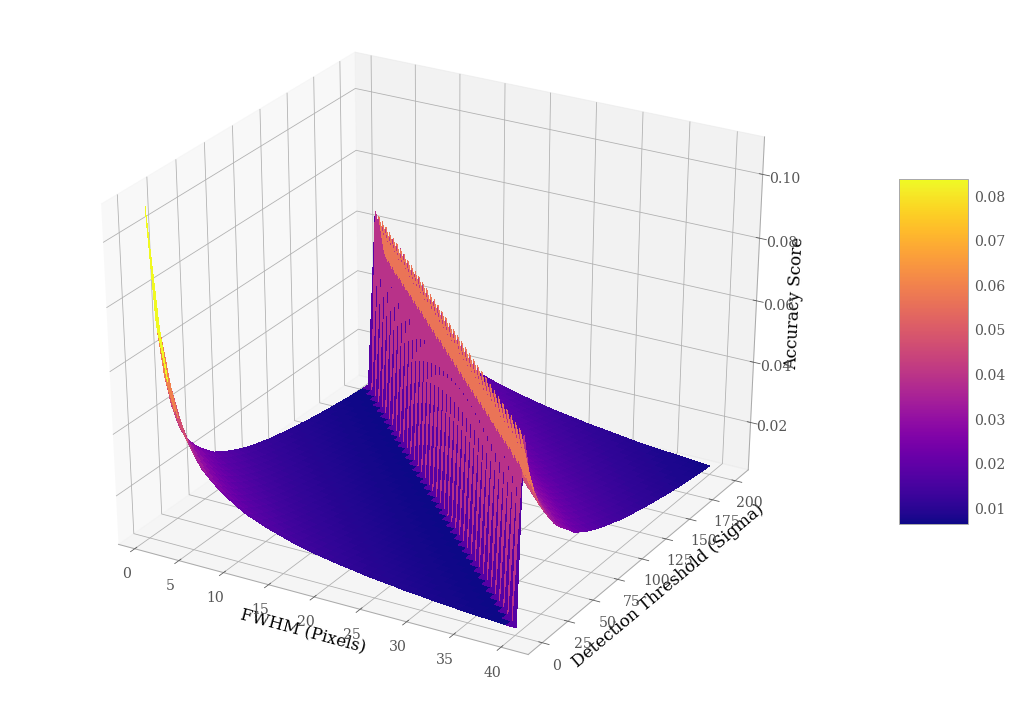

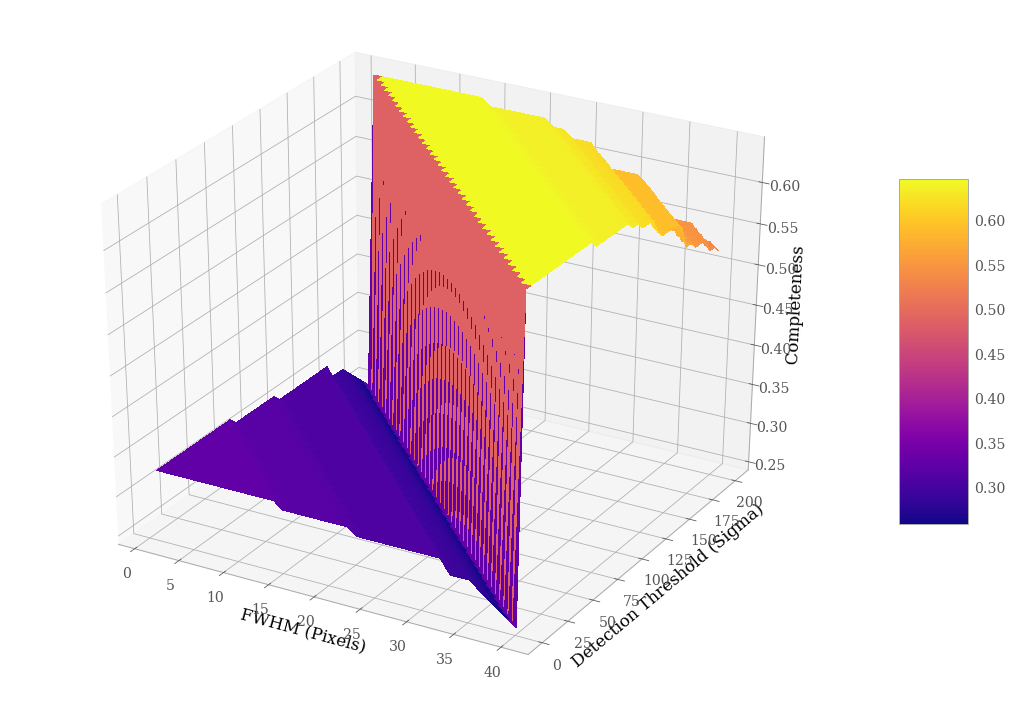

gauss_3.0_5x5.conv


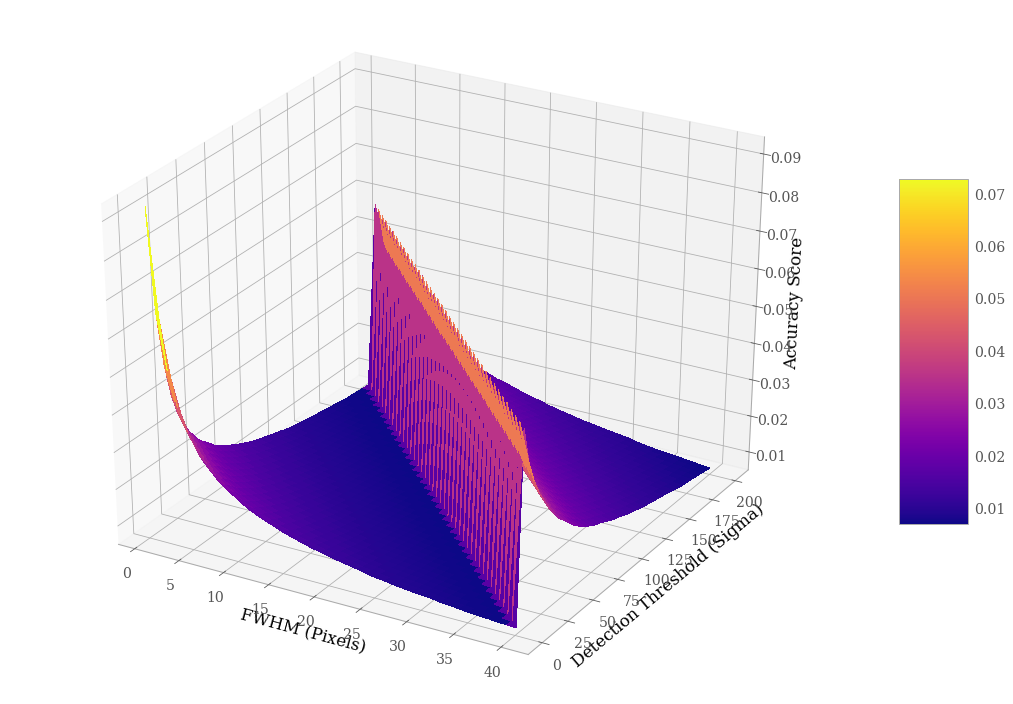

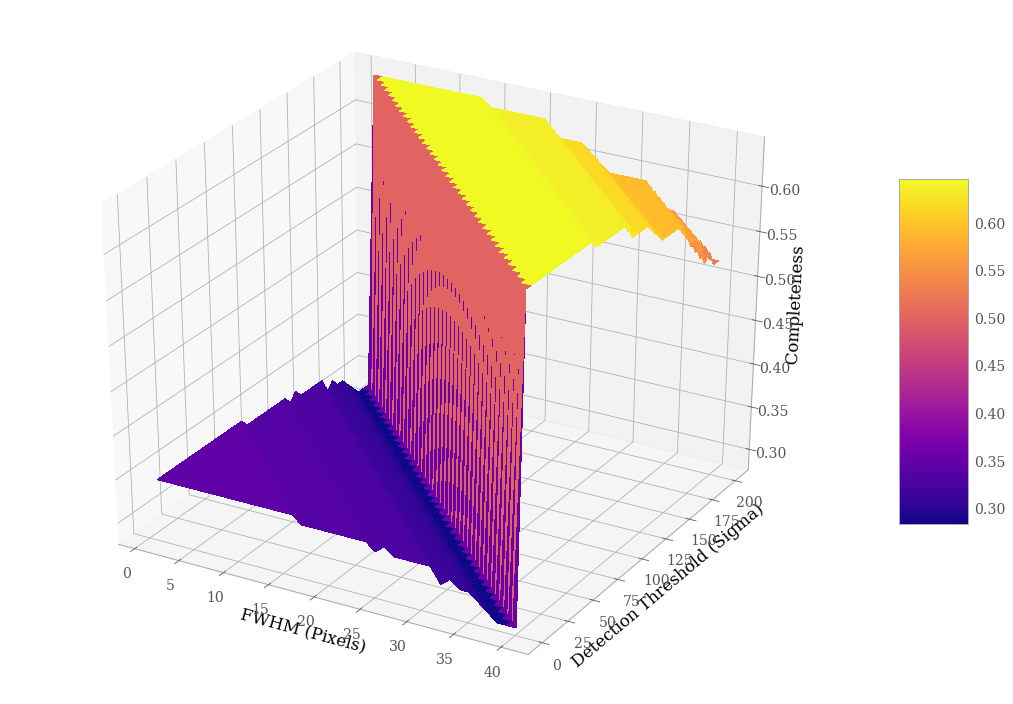

gauss_3.0_7x7.conv


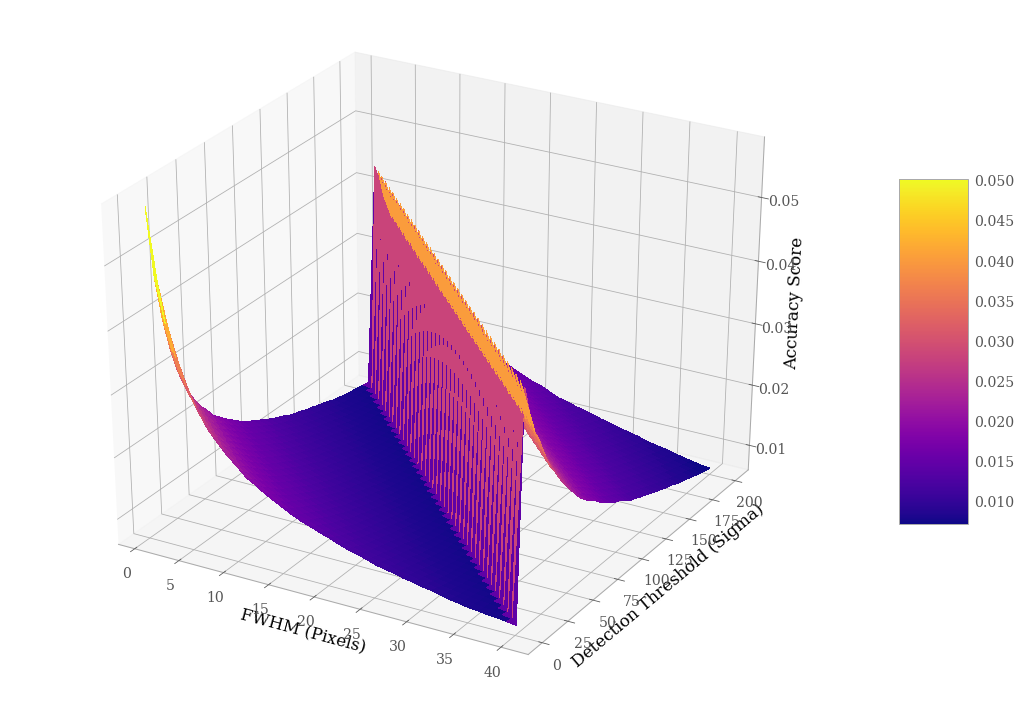

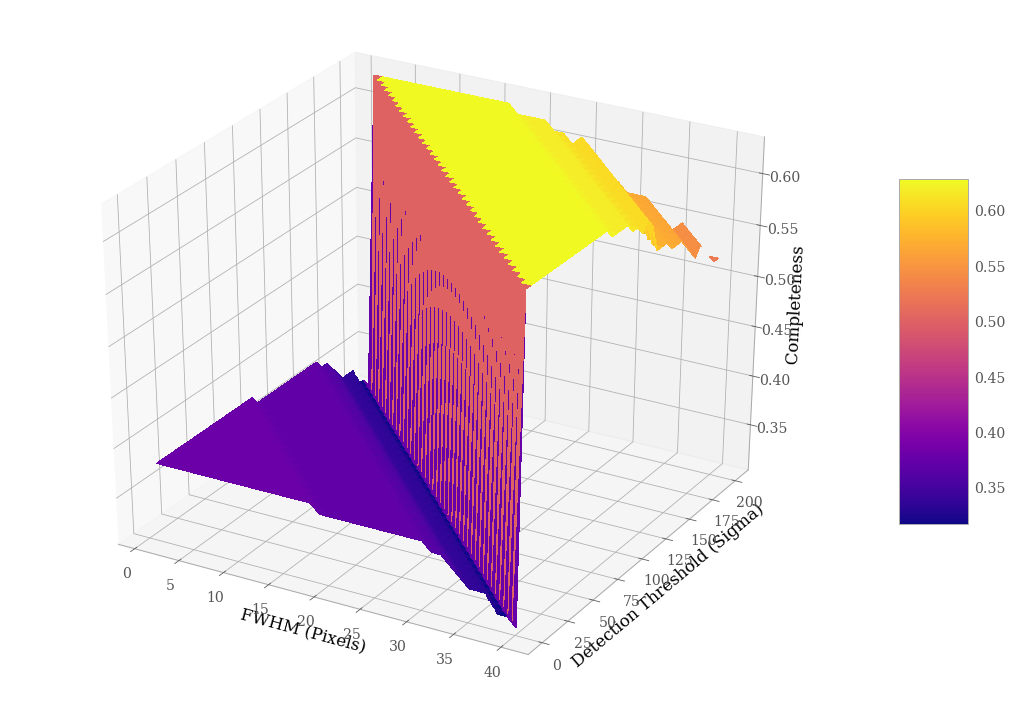

gauss_4.0_7x7.conv


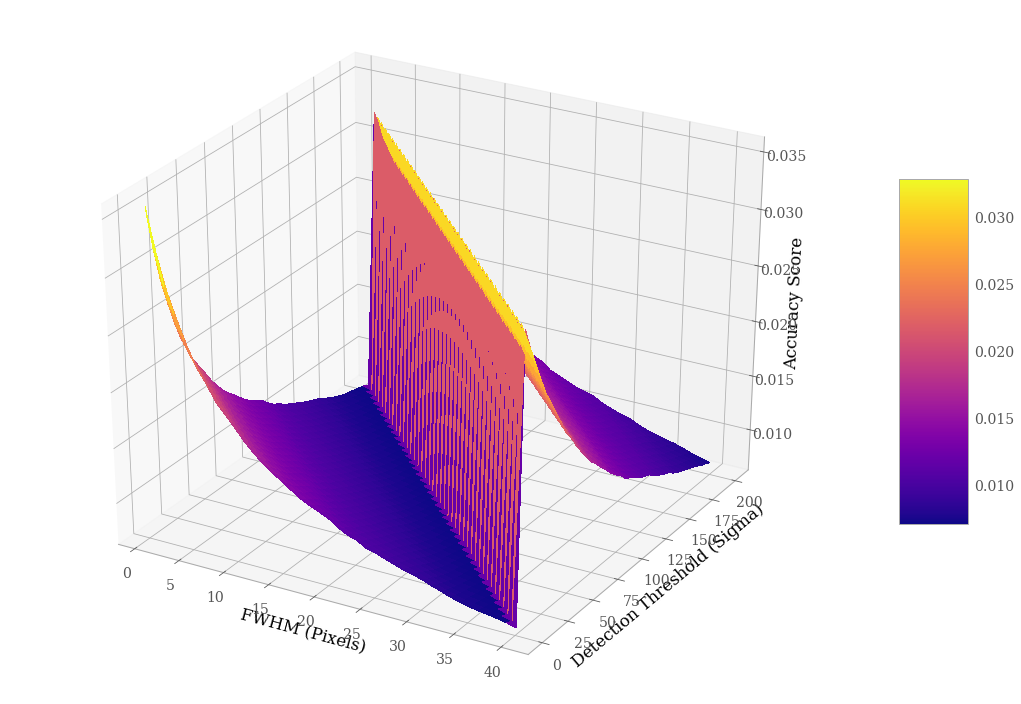

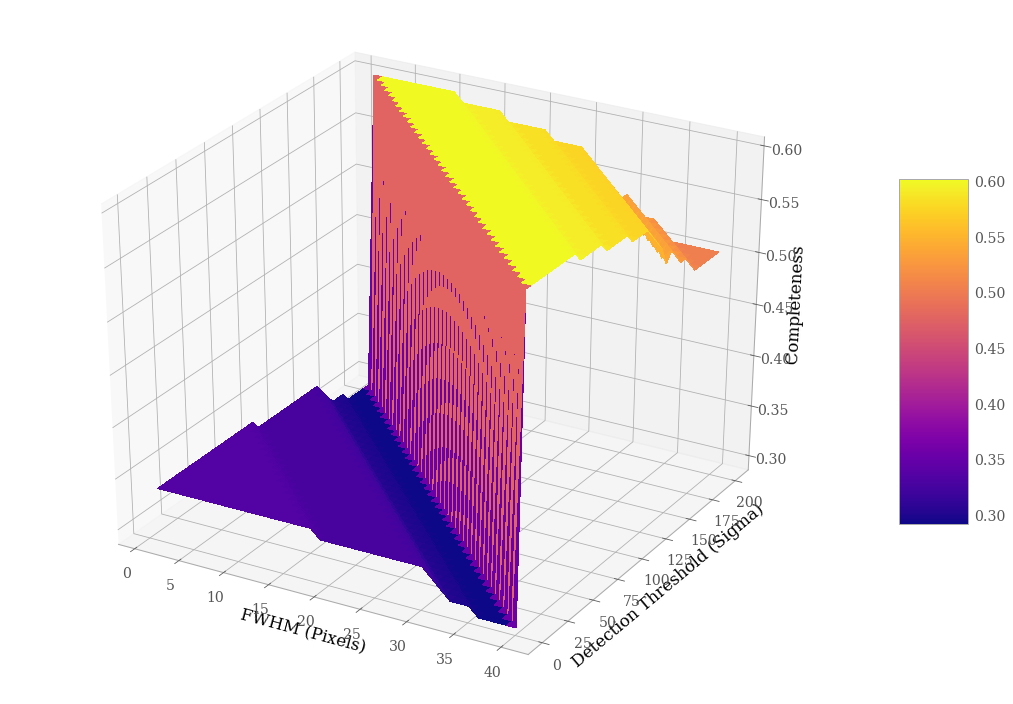

gauss_5.0_9x9.conv


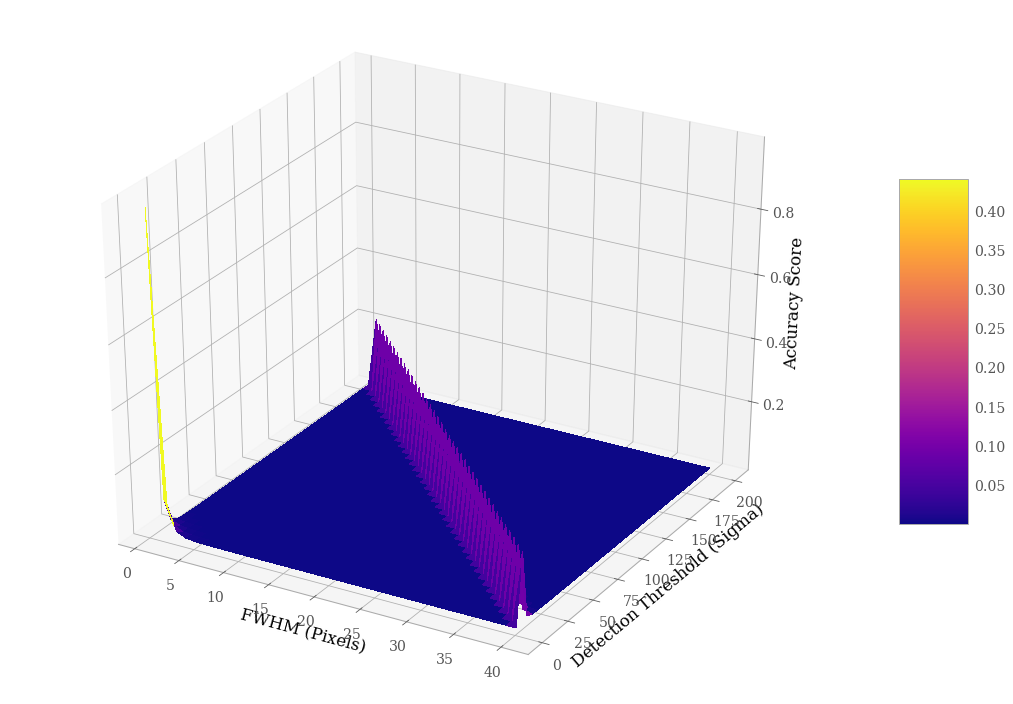

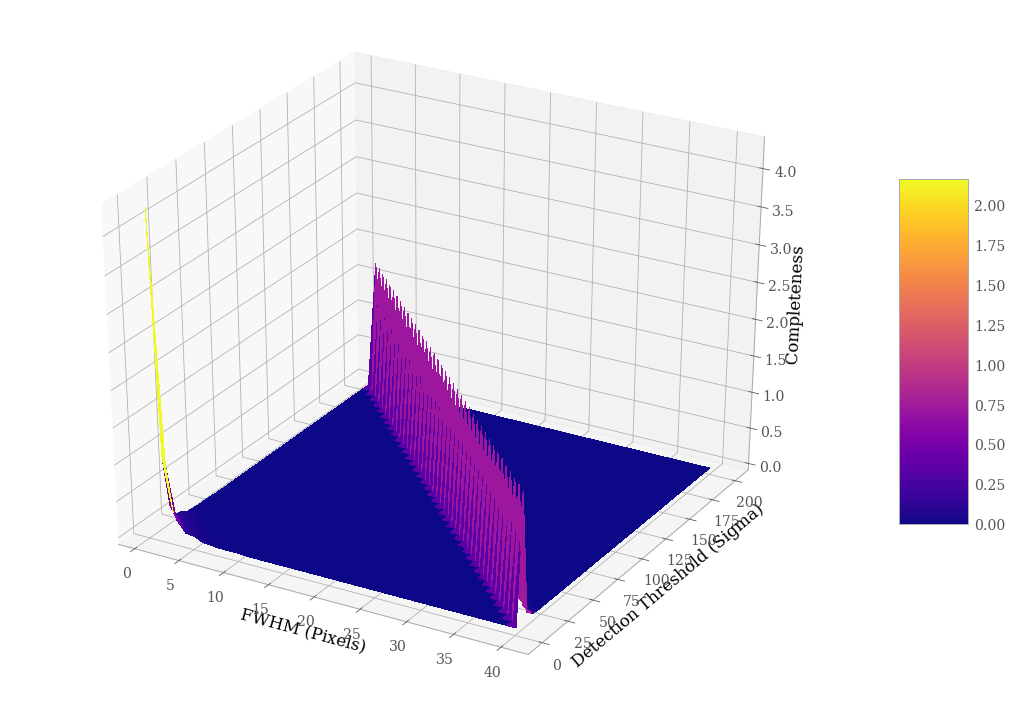

mexhat_1.5_5x5.conv


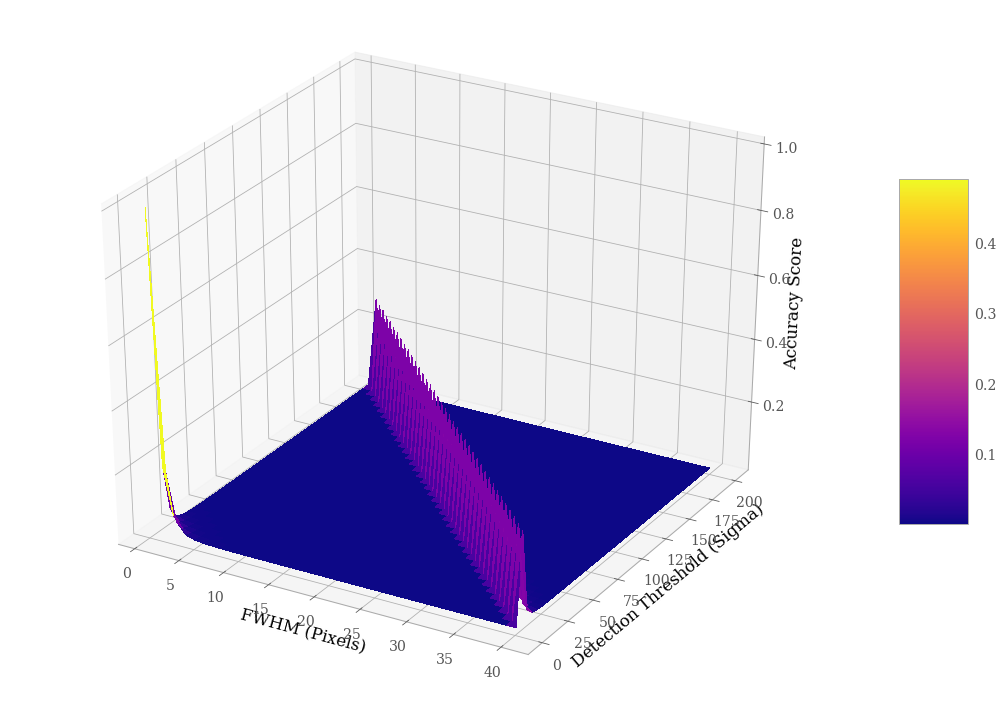

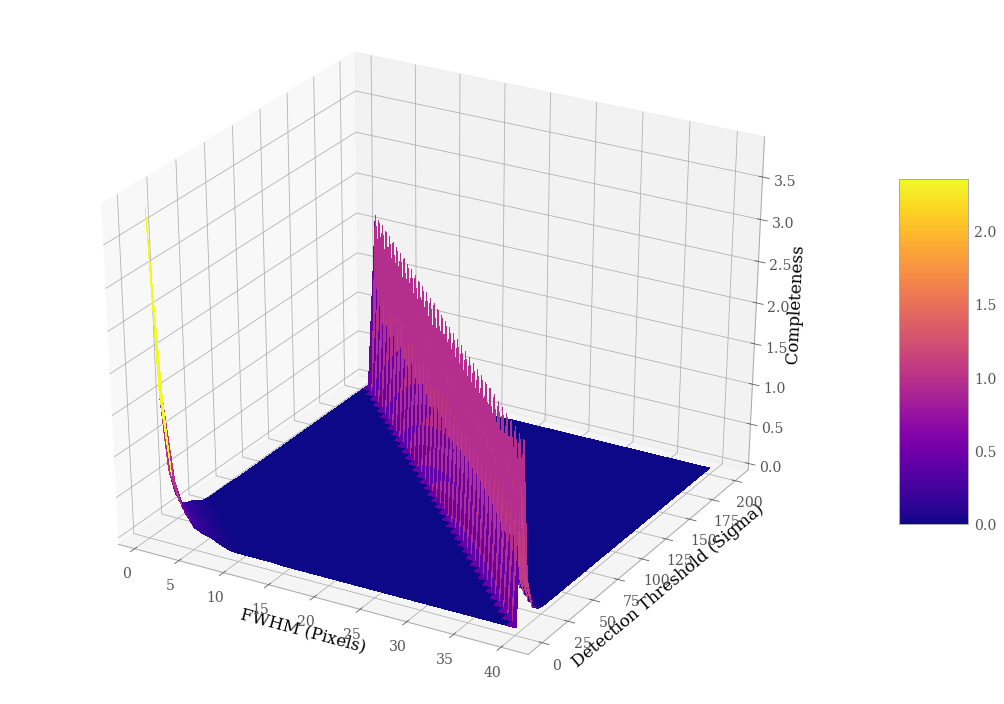

mexhat_2.0_7x7.conv


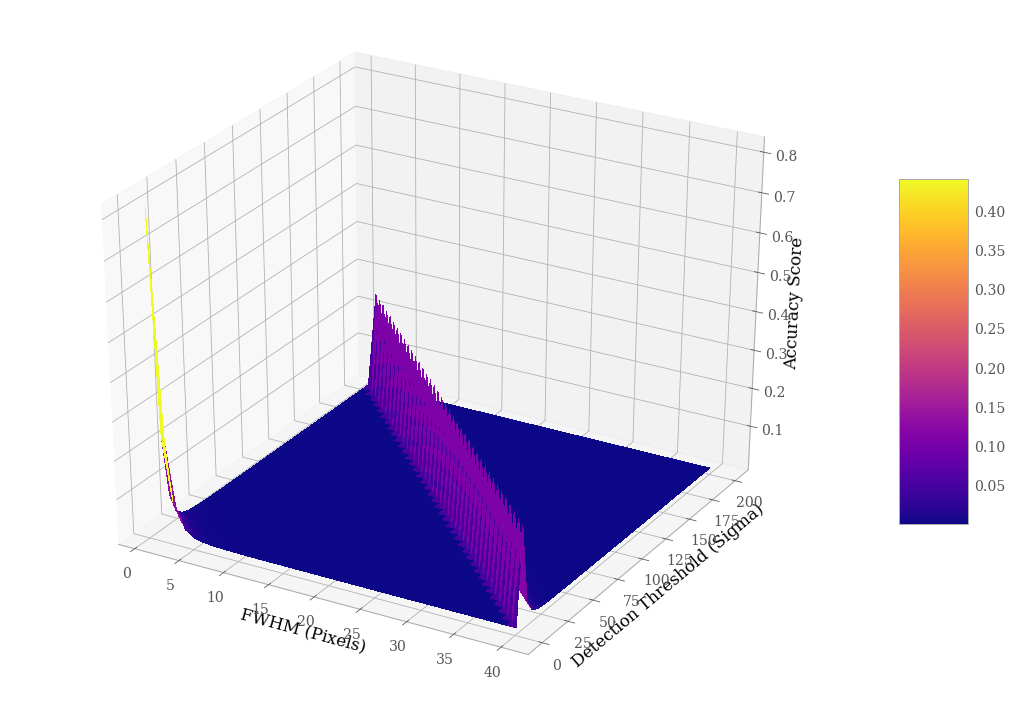

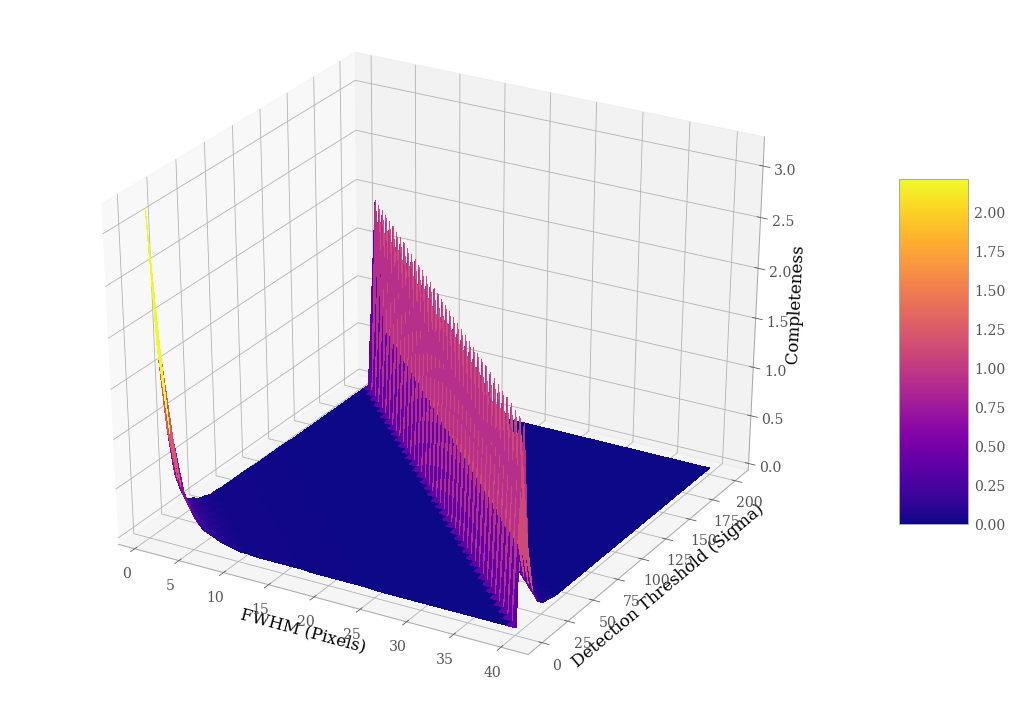

mexhat_2.5_7x7.conv


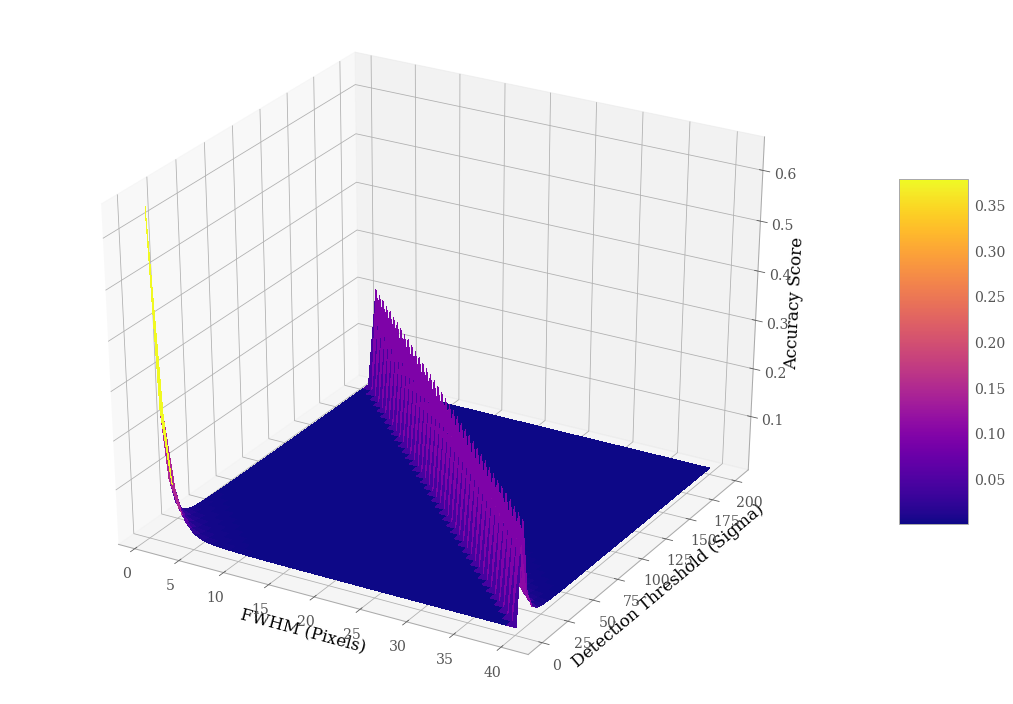

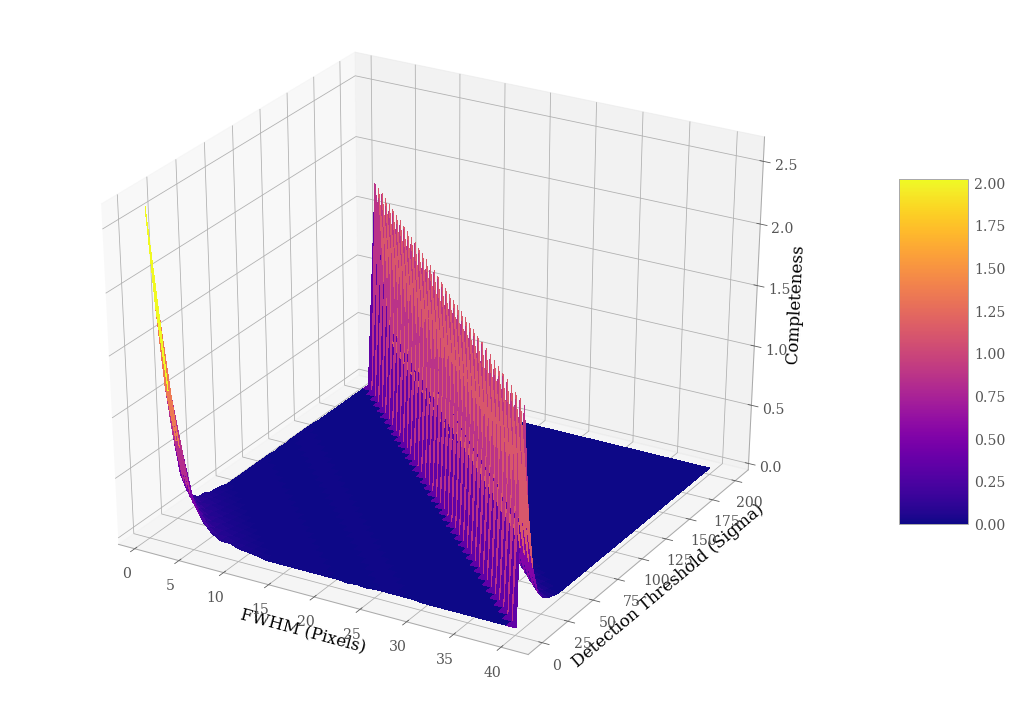

mexhat_3.0_9x9.conv


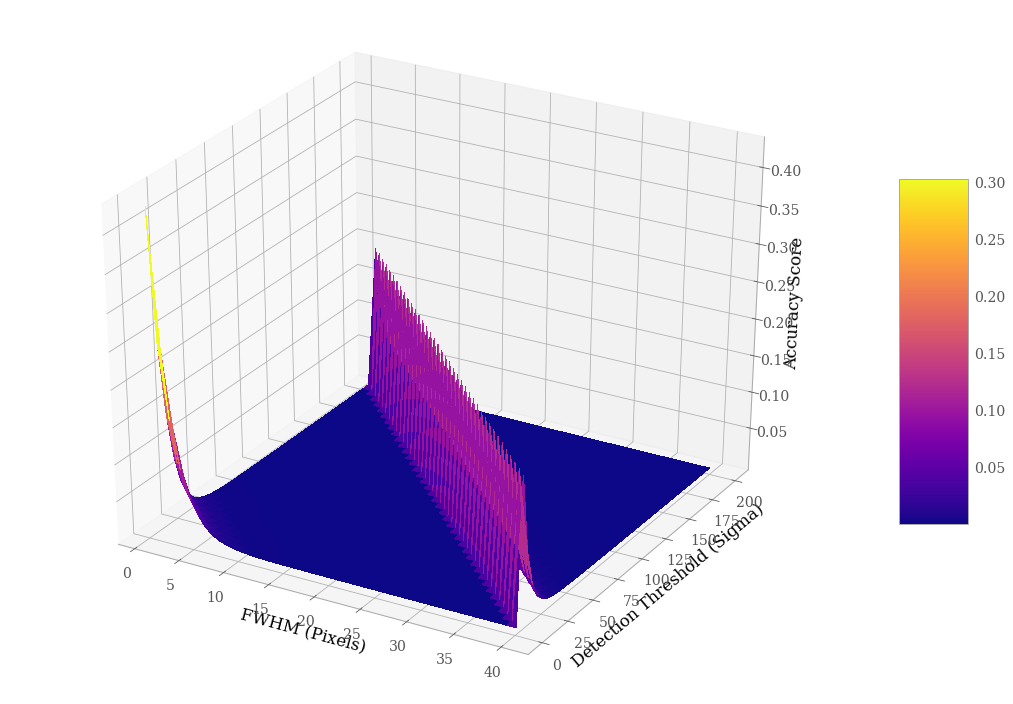

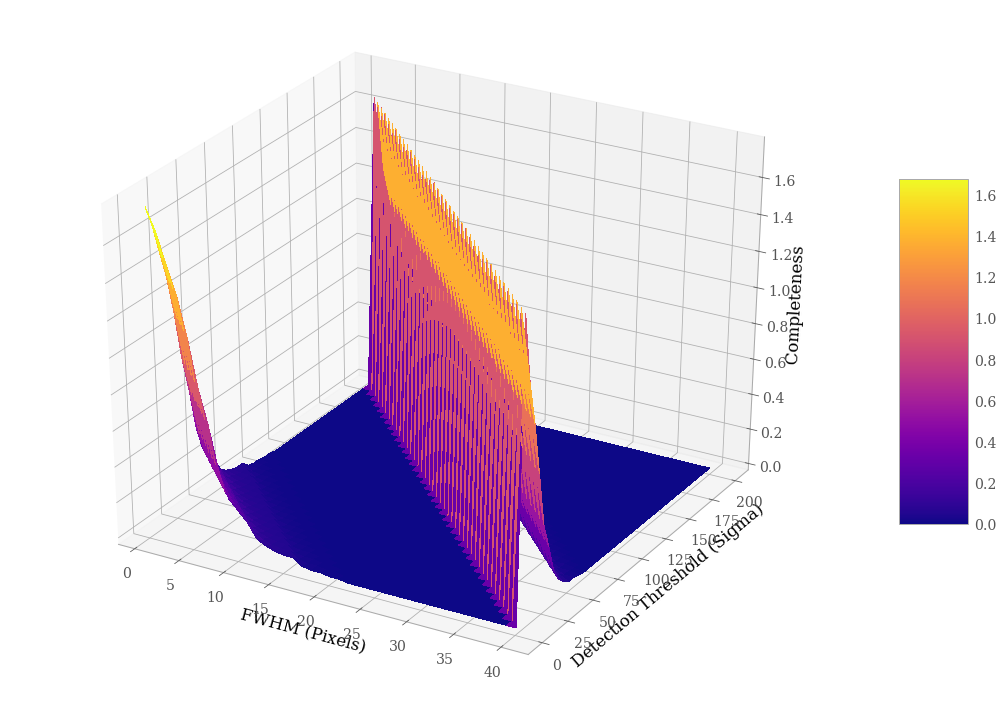

mexhat_4.0_9x9.conv


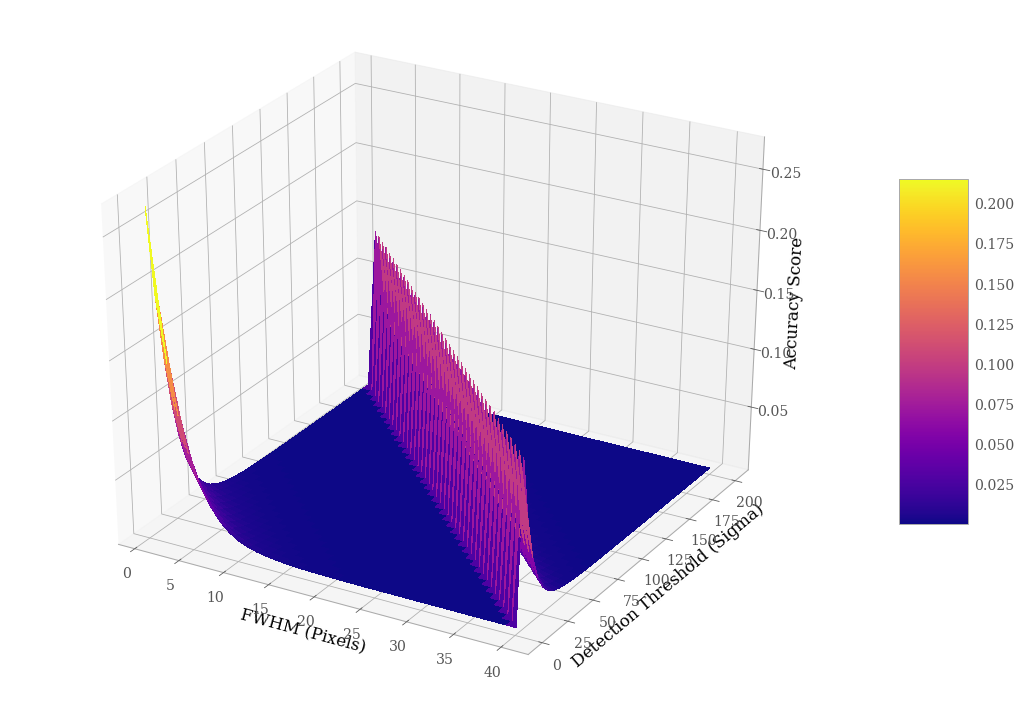

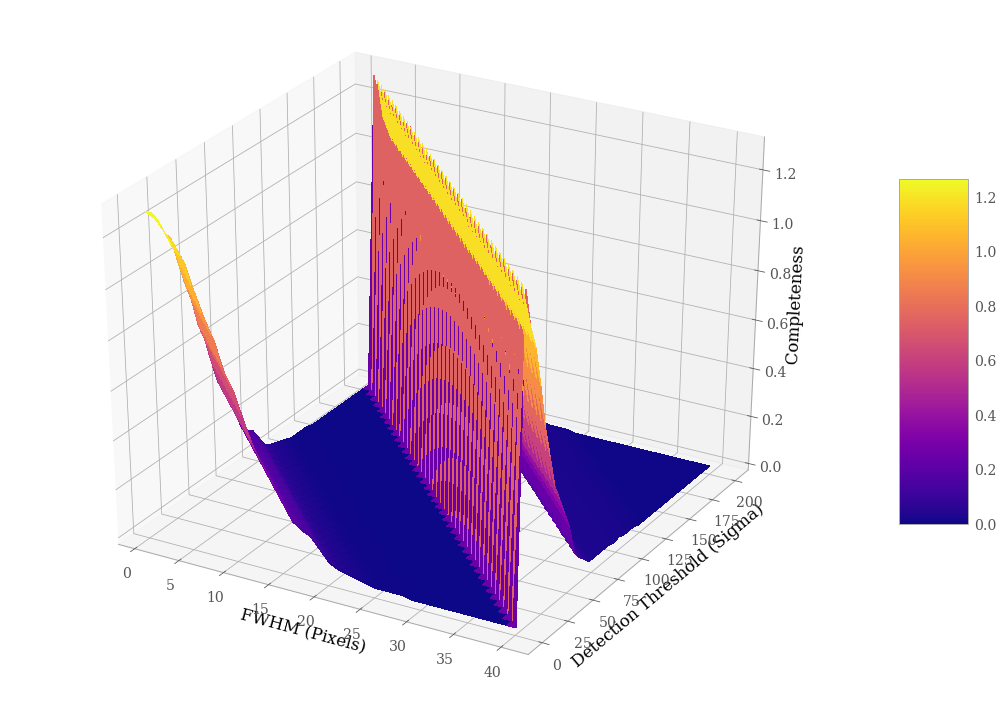

mexhat_5.0_11x11.conv


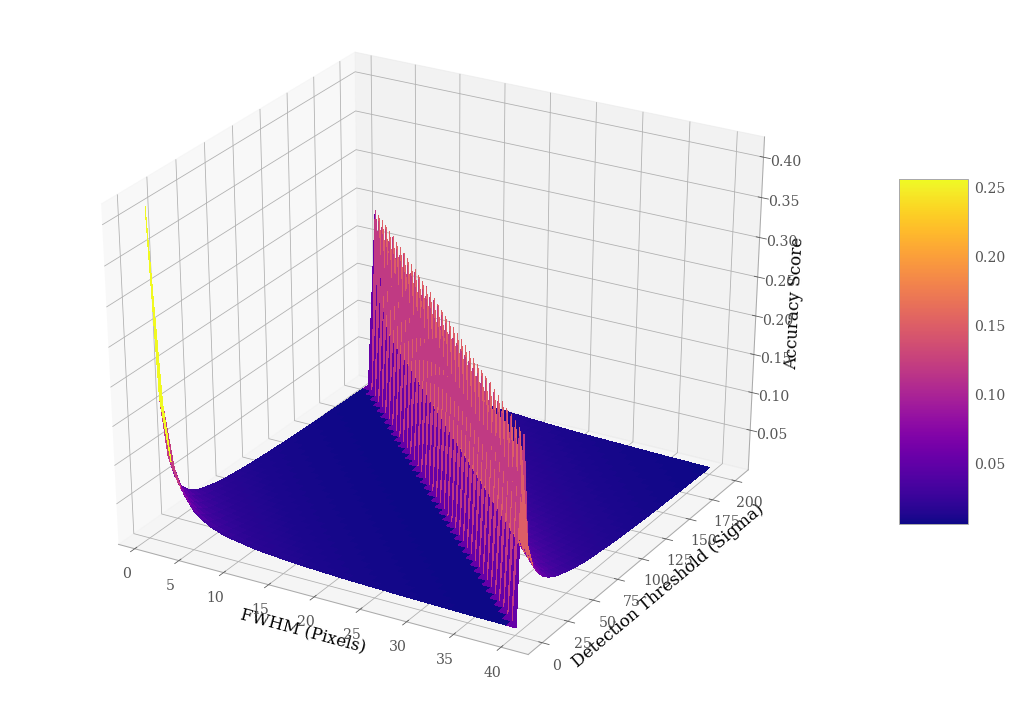

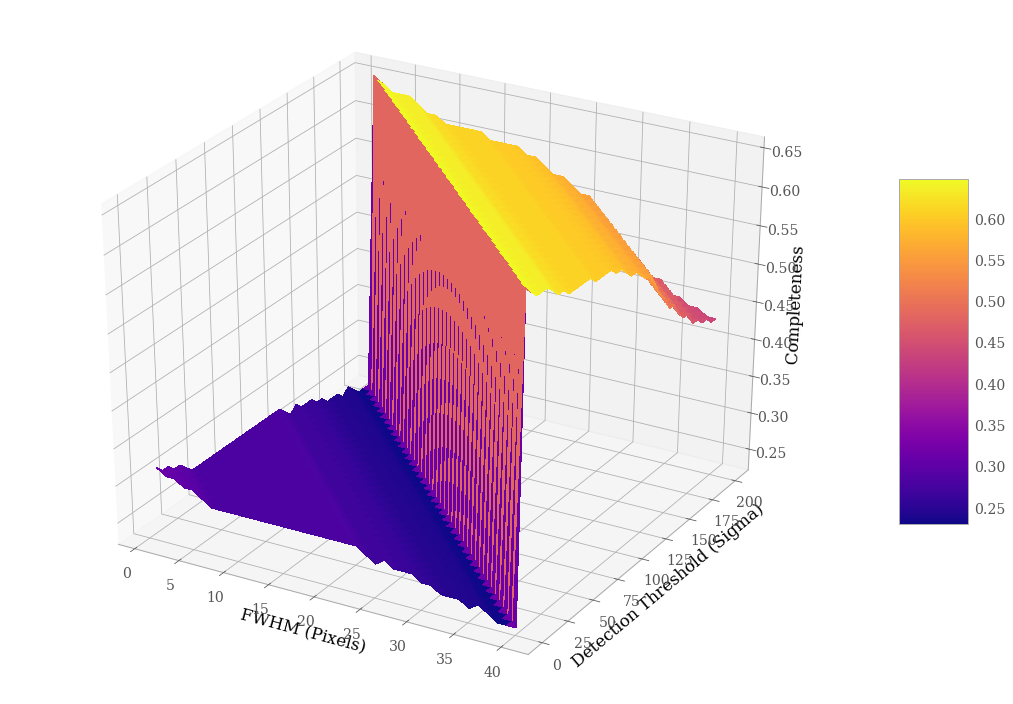

tophat_1.5_3x3.conv


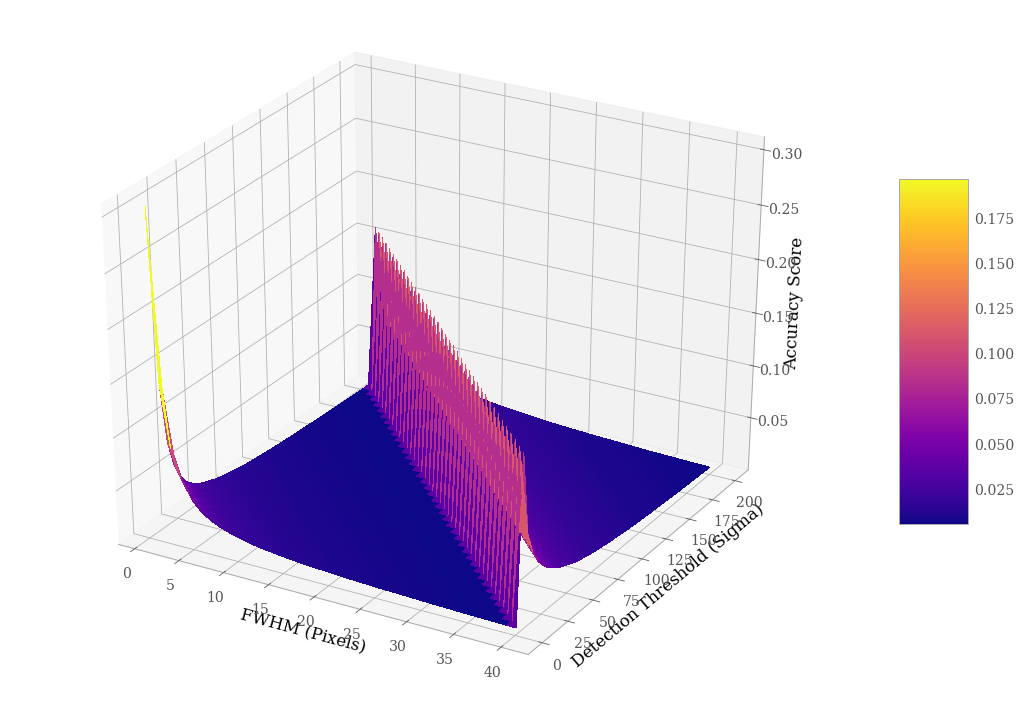

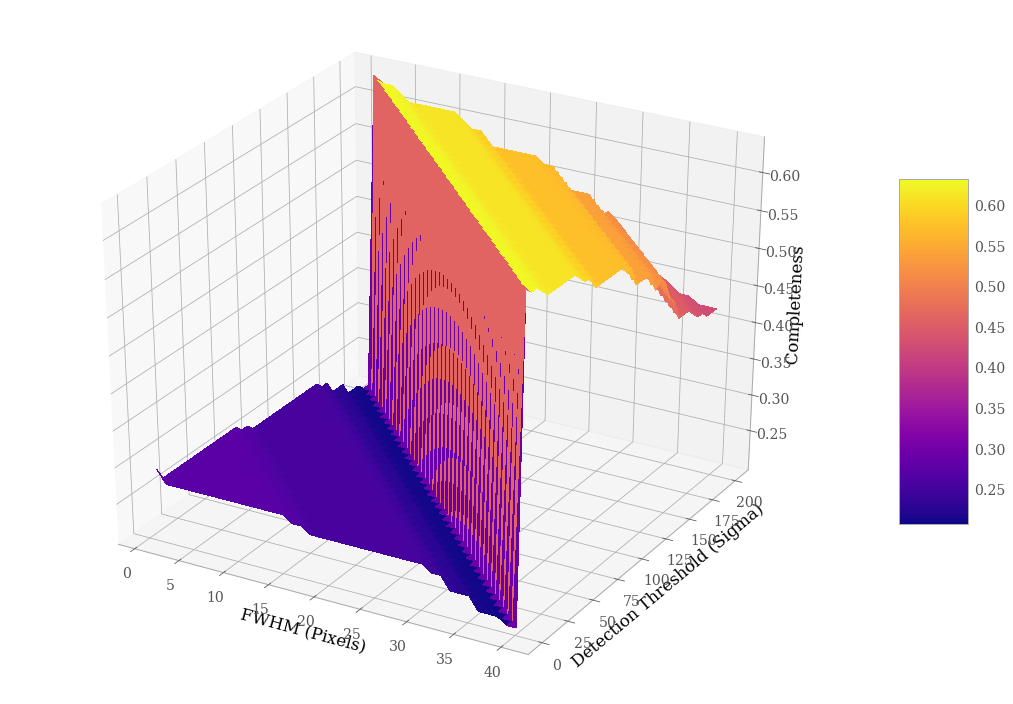

tophat_2.0_3x3.conv


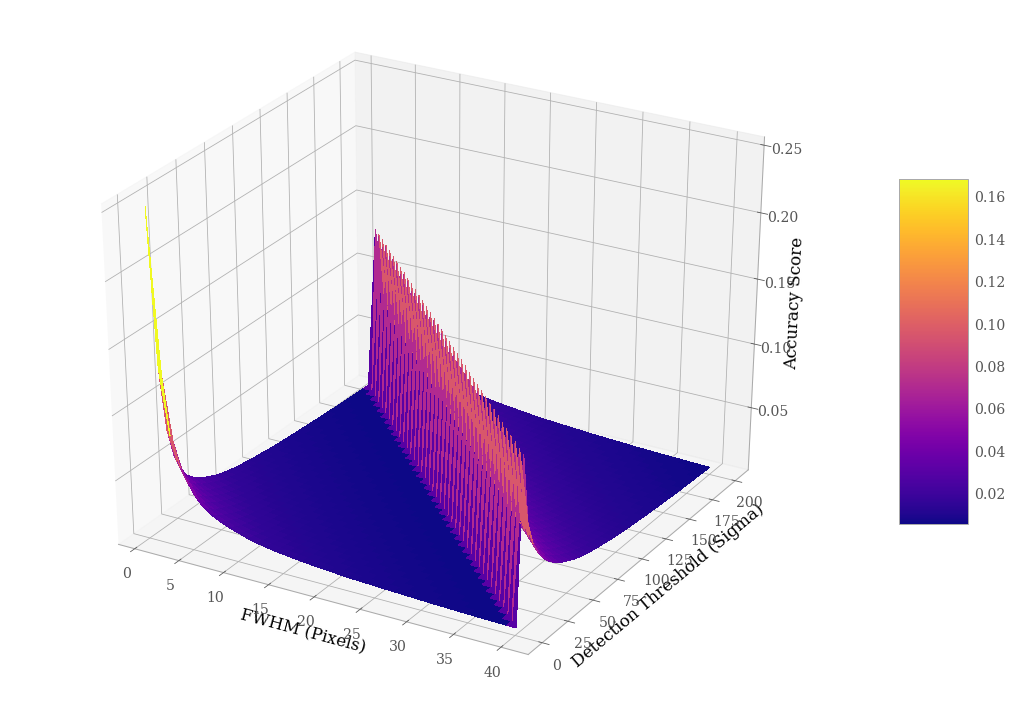

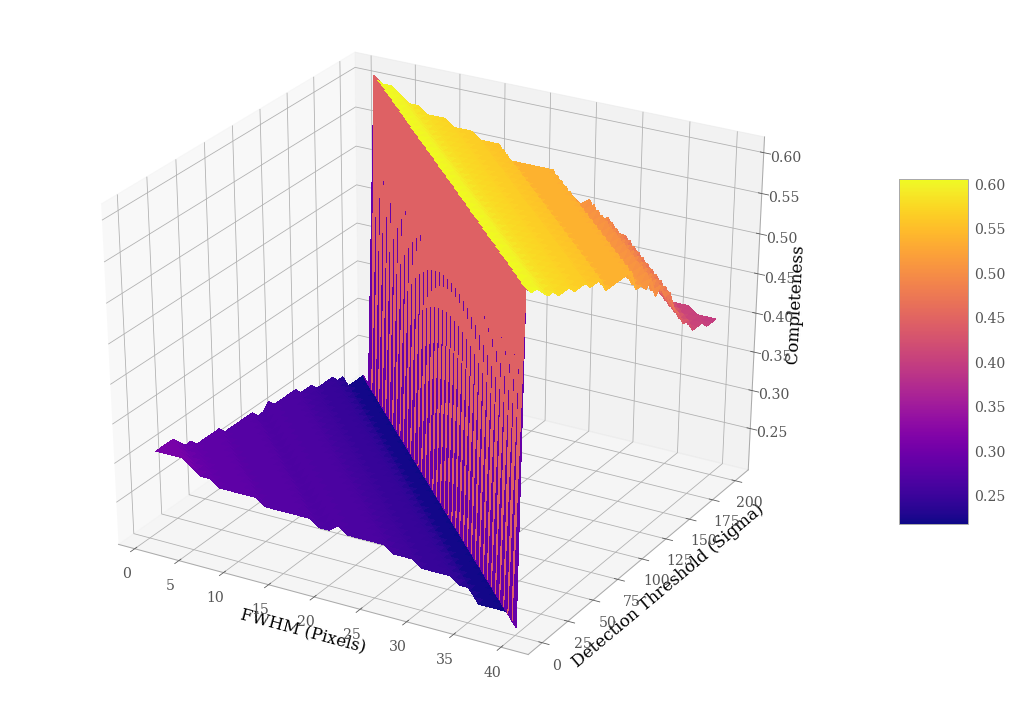

tophat_2.5_3x3.conv


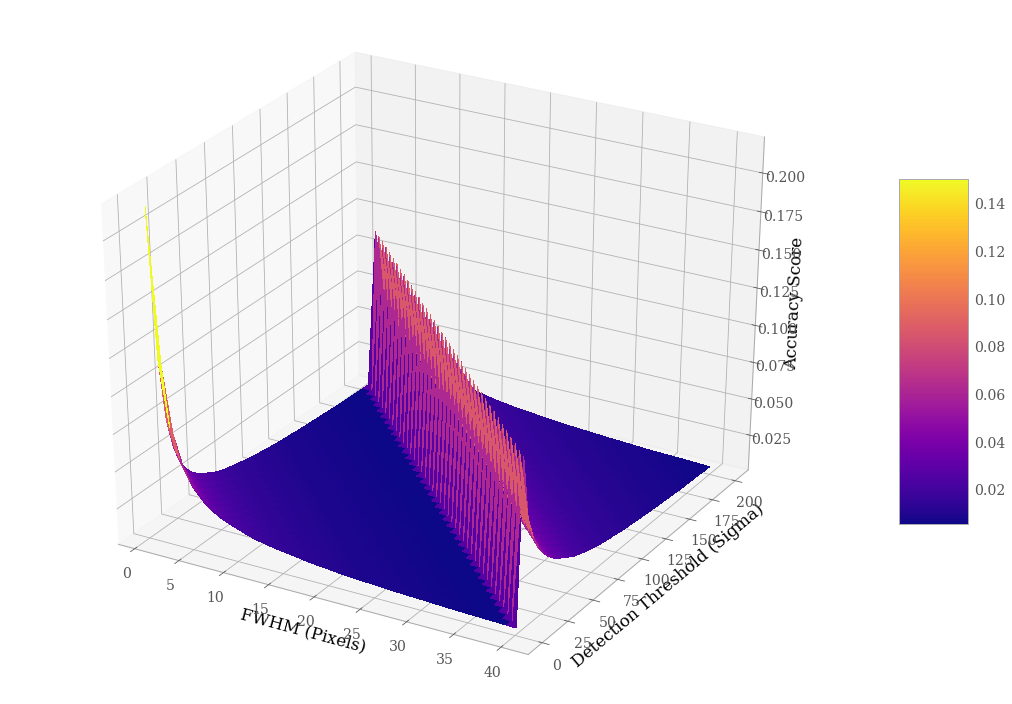

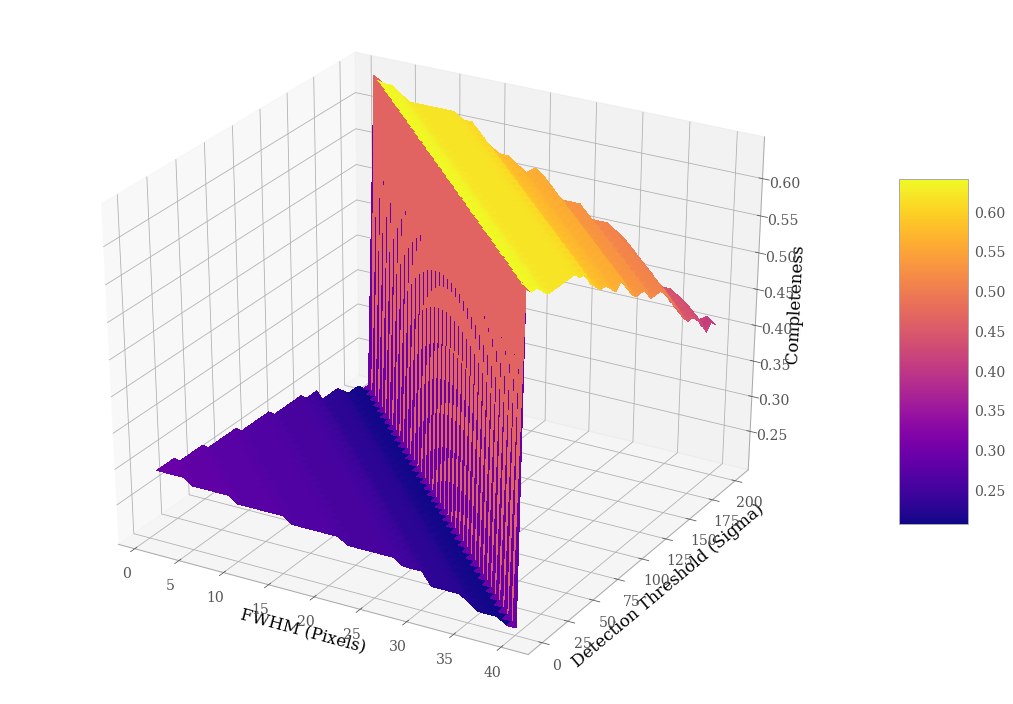

tophat_3.0_3x3.conv


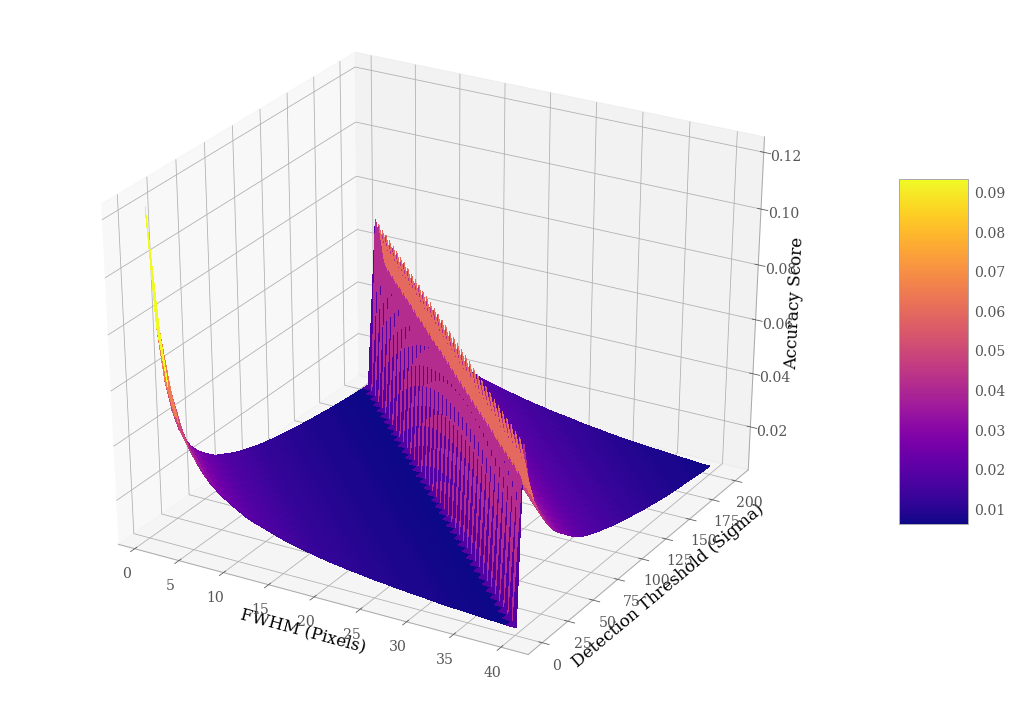

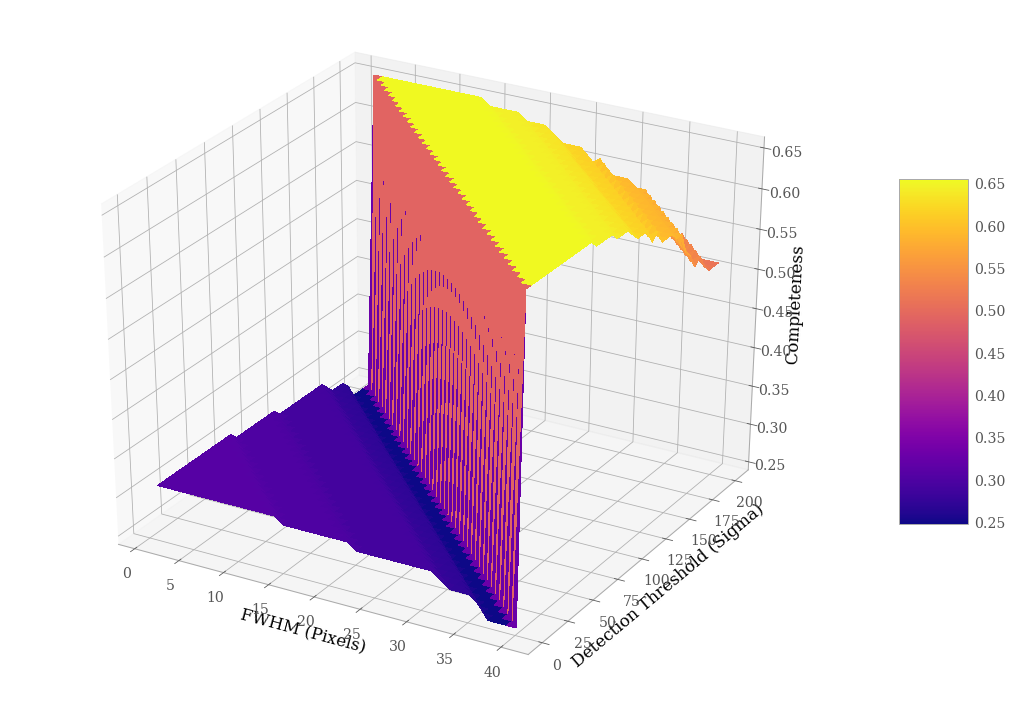

tophat_4.0_5x5.conv


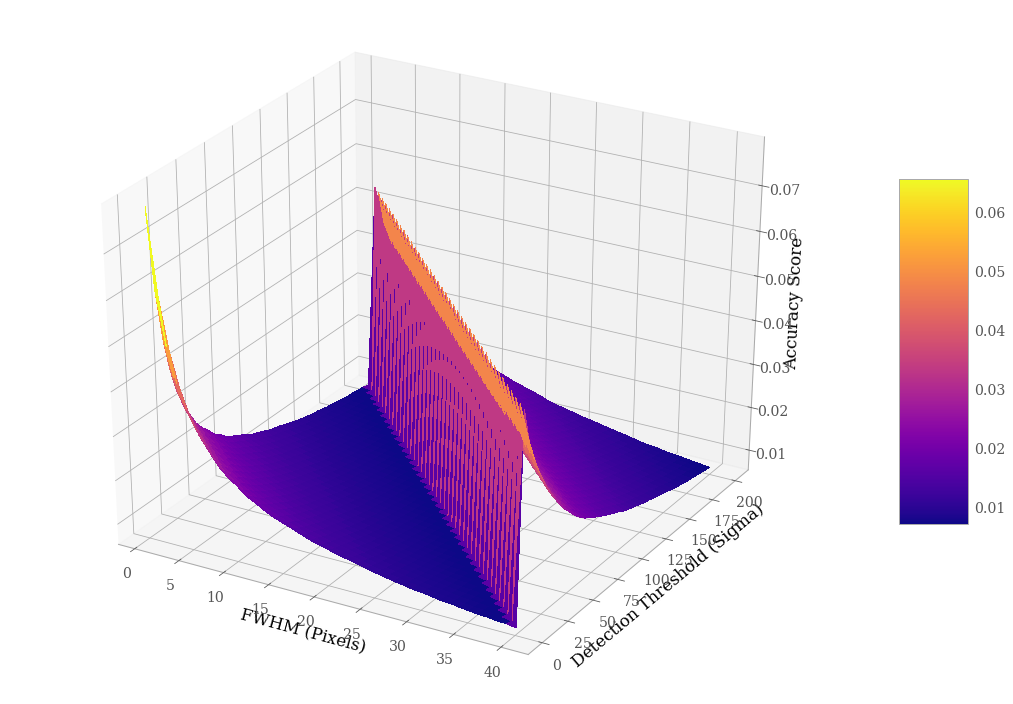

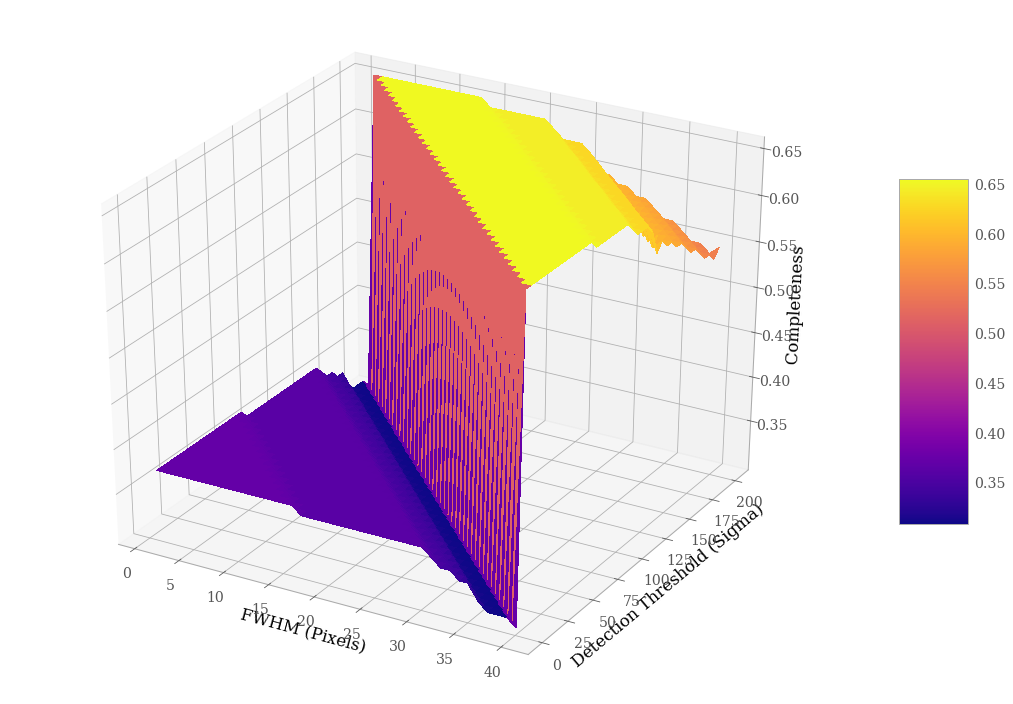

tophat_5.0_5x5.conv


In [247]:
# accReformat = []
# compReformat = []
#totQualityReformat = []
for y in range(len(valList[2])):
    accReformat = []
    compReformat = []
    for x in range(int(len(accPerfilter[y])/len(fullwhm))):
        accReformat.append(accPerfilter[y][x:x+len(fullwhm)])
        #print(accPerfilter[0][x:x+len(fullwhm)])
        compReformat.append(compPerFilter[y][x:x+len(fullwhm)])
        #totQualityReformat.append(tot[x:x+len(fullwhm)])
        
#     fig = plt.figure(figsize=(15,10))
#     ax = fig.gca(projection='3d')

    font = {'family' : 'serif',
            'weight' : 'normal',
            'size'   : 14}
    plt.rc('font', **font)
    plt.rc('axes',linewidth=1)
    #surf = ax.plot_surface(X,Y,Z,cmap='plasma',linewidth=0,antialiased=False)
    fig = plt.figure(figsize=(15,10))
    ax = fig.gca(projection='3d')
    X,Y = np.meshgrid(fullwhm,threshold)
    Z = np.array(accReformat)
    surf = ax.plot_surface(X,Y,Z,cmap='plasma',linewidth=0,antialiased=False)

    fig.colorbar(surf, shrink=0.5, aspect=5)
    #plt.gca().invert_zaxis()
    plt.xlabel('FWHM (Pixels)')
    plt.ylabel('Detection Threshold (Sigma)')
    ax.set_zlabel('Accuracy Score')
    plt.tight_layout()
    plt.savefig('/home/mj1e16/moleGazer/MoleGazer/acc_medium_filter_{}_sextractor.png'.format(valList[2][y]))
    plt.show()
    
#     fig = plt.figure(figsize=(15,10))
#     ax = fig.gca(projection='3d')

    font = {'family' : 'serif',
            'weight' : 'normal',
            'size'   : 14}
    plt.rc('font', **font)
    plt.rc('axes',linewidth=1)
    #surf = ax.plot_surface(X,Y,Z,cmap='plasma',linewidth=0,antialiased=False)
    fig = plt.figure(figsize=(15,10))
    ax = fig.gca(projection='3d')
    X,Y = np.meshgrid(fullwhm,threshold)
    Z = np.array(compReformat)
    surf = ax.plot_surface(X,Y,Z,cmap='plasma',linewidth=0,antialiased=False)

    fig.colorbar(surf, shrink=0.5, aspect=5)
    #plt.gca().invert_zaxis()
    plt.xlabel('FWHM (Pixels)')
    plt.ylabel('Detection Threshold (Sigma)')
    ax.set_zlabel('Completeness')
    plt.tight_layout()
    plt.savefig('/home/mj1e16/moleGazer/MoleGazer/qualityCurves/comp_medium_filter_{}_sextractor.png'.format(valList[2][y]))
    plt.show()
    
    print(valList[2][y])

In [186]:
print(len(fullwhm))
print(len(threshold))
print(len(accReformat))
print(len(accReformat[0]))

20
20
20
20


In [187]:
accReformat

[[0.26364922206506364,
  0.12992362093352192,
  0.08066760961810467,
  0.05825176803394625,
  0.04623479490806223,
  0.03731824611032532,
  0.03214710042432815,
  0.02857142857142857,
  0.026014144271570012,
  0.023660537482319662,
  0.021295615275813296,
  0.019756718528995756,
  0.018455445544554454,
  0.017278642149929278,
  0.01645261669024045,
  0.015185289957567185,
  0.014336633663366337,
  0.013567185289957567,
  0.012876944837340877,
  0.012311173974540311],
 [0.12992362093352192,
  0.08066760961810467,
  0.05825176803394625,
  0.04623479490806223,
  0.03731824611032532,
  0.03214710042432815,
  0.02857142857142857,
  0.026014144271570012,
  0.023660537482319662,
  0.021295615275813296,
  0.019756718528995756,
  0.018455445544554454,
  0.017278642149929278,
  0.01645261669024045,
  0.015185289957567185,
  0.014336633663366337,
  0.013567185289957567,
  0.012876944837340877,
  0.012311173974540311,
  0.13421216407355022],
 [0.08066760961810467,
  0.05825176803394625,
  0.046234

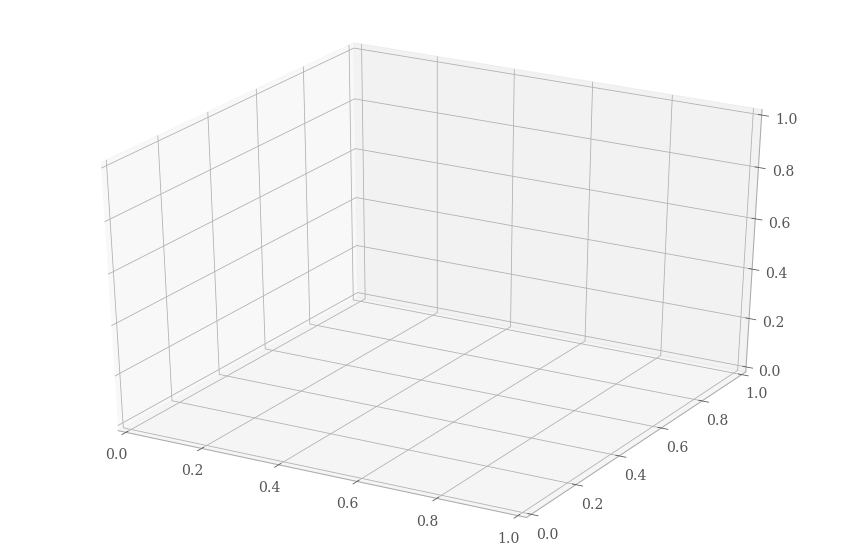

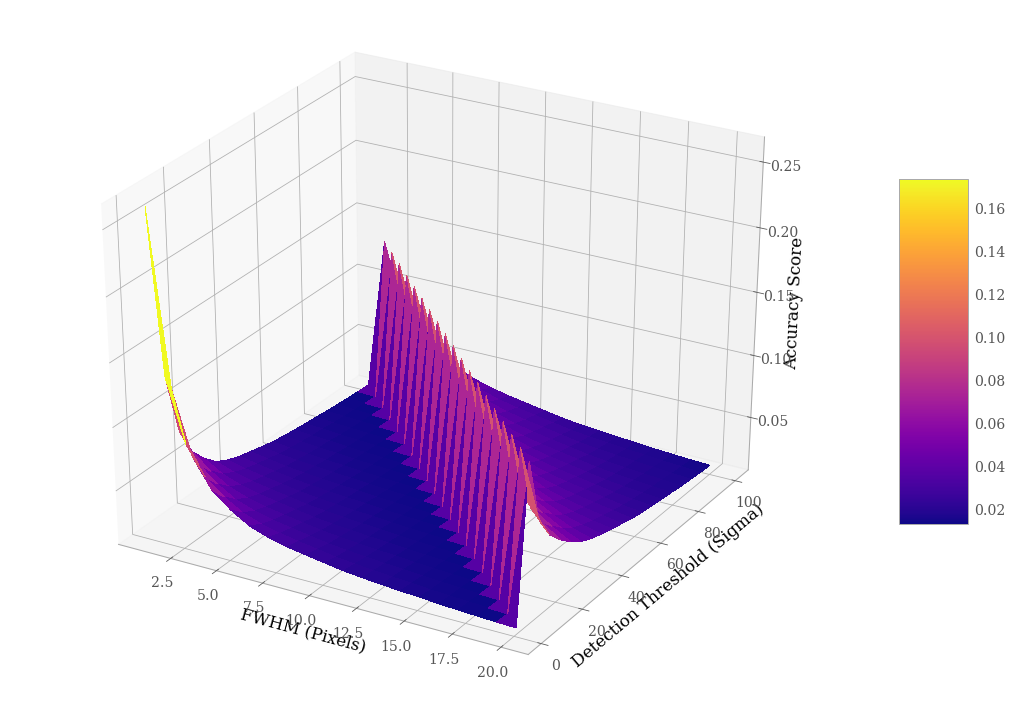

In [191]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('axes',linewidth=1)
#surf = ax.plot_surface(X,Y,Z,cmap='plasma',linewidth=0,antialiased=False)
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')
X,Y = np.meshgrid(fullwhm,threshold)
Z = np.array(accReformat)
surf = ax.plot_surface(X,Y,Z,cmap='plasma',linewidth=0,antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)
#plt.gca().invert_zaxis()
plt.xlabel('FWHM (Pixels)')
plt.ylabel('Detection Threshold (Sigma)')
ax.set_zlabel('Accuracy Score')
plt.tight_layout()
plt.savefig('/home/mj1e16/moleGazer/MoleGazer/accAverageImMeidumSim.png')
plt.show()

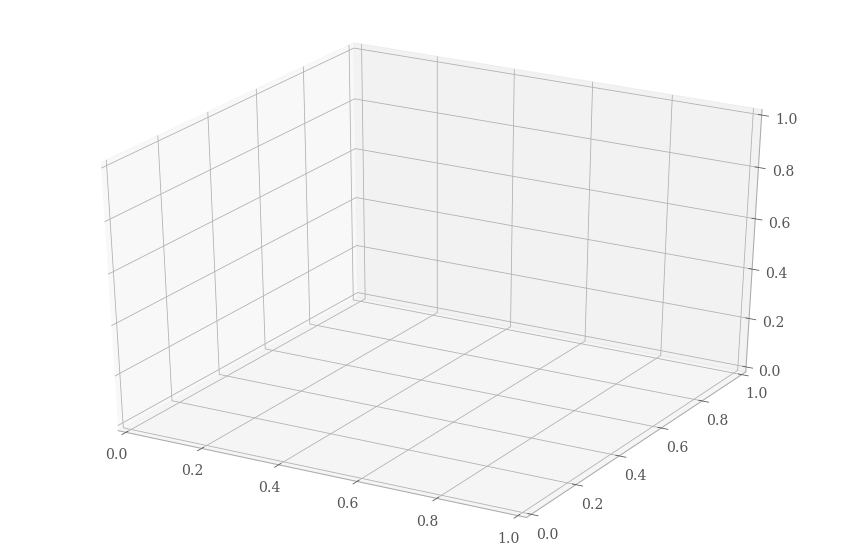

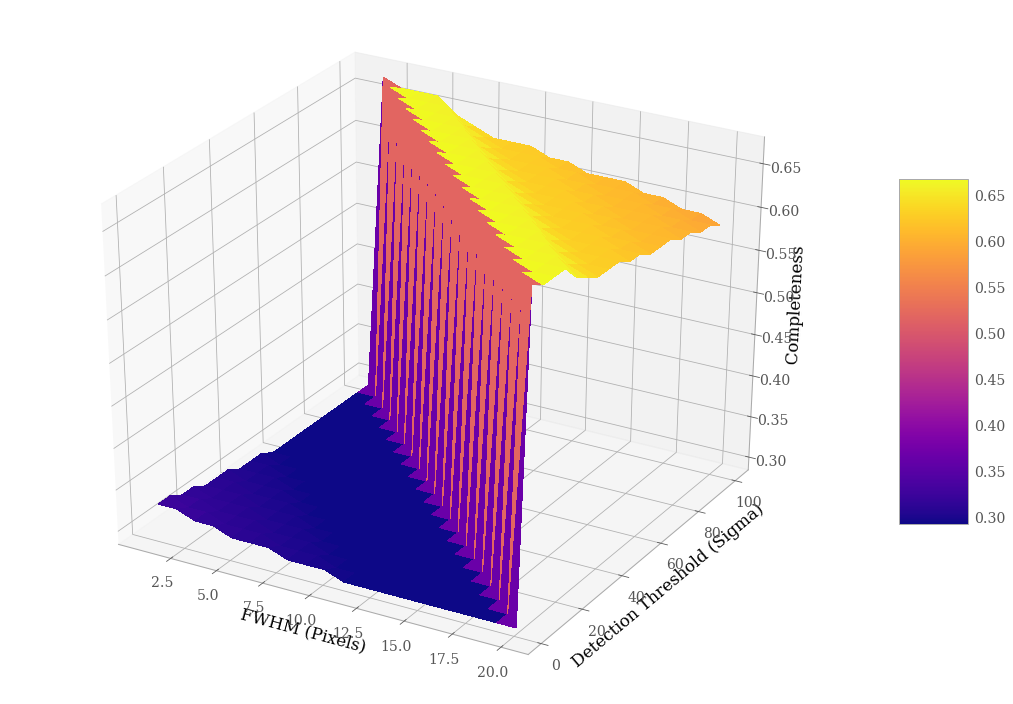

In [190]:
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('axes',linewidth=1)
#surf = ax.plot_surface(X,Y,Z,cmap='plasma',linewidth=0,antialiased=False)
fig = plt.figure(figsize=(15,10))
ax = fig.gca(projection='3d')
X,Y = np.meshgrid(fullwhm,threshold)
Z = np.array(compReformat)
surf = ax.plot_surface(X,Y,Z,cmap='plasma',linewidth=0,antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)
#plt.gca().invert_zaxis()
plt.xlabel('FWHM (Pixels)')
plt.ylabel('Detection Threshold (Sigma)')
ax.set_zlabel('Completeness')
plt.tight_layout()
plt.savefig('/home/mj1e16/moleGazer/MoleGazer/compAverageImMeidumSim.png')
plt.show()